In [1]:
import json
import numpy as np
from neuralNetwork import NeuralNetwork, In_between_epochs
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer, AutoTokenizer, AutoModel
from helper import dict_lists_to_list_of_dicts, get_train_valdiation_test_split, Dataset
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
from transformers import logging
logging.set_verbosity_error()

### Importing the dataset:

In [2]:
f = open("ECHR_Corpus.json",encoding= 'utf-8')
dataset = json.load(f)
f.close()

In [3]:
refactored_dataset = []
for datapoint in dataset:
    text = datapoint["text"]
    dict_clauses = {}
    for clause in datapoint["clauses"]:
        start = clause["start"]
        end = clause["end"]
        id = clause["_id"]
        dict_clauses[id] = text[start:end]
    refactored_dataset.append({
        "text": text,
        "arguments": datapoint["arguments"],
        "n_clauses": len(datapoint["clauses"]),
        "all_clauses": dict_clauses
    })

In [4]:
n_arguments = []
n_premises = []
n_clauses = []
for case in refactored_dataset:
    n_arguments.append(len(case["arguments"]))
    n_clauses.append(case["n_clauses"])
    for argument in case["arguments"]:
        n_premises.append(len(argument["premises"]))
print(f"""
On average, a case has {np.mean(n_clauses):.2f} clauses with a median of {np.median(n_clauses):.0f} clauses per case.
On average, a case has {np.mean(n_arguments):.2f} arguments with a median of {np.median(n_arguments):.0f} arguments per case.
Each argument, on average, has: {np.mean(n_premises):.2f} premises with a median of {np.median(n_premises):.0f} premises per argument.
""")


On average, a case has 248.95 clauses with a median of 226 clauses per case.
On average, a case has 17.69 arguments with a median of 14 arguments per case.
Each argument, on average, has: 2.63 premises with a median of 2 premises per argument.



In [5]:
premise = "\n\t".join([refactored_dataset[0]["all_clauses"][premise] for premise in refactored_dataset[0]["arguments"][0]["premises"]])
conclusion = refactored_dataset[0]["all_clauses"][refactored_dataset[0]["arguments"][0]["conclusion"]]
print(f"""
Here an example of an argument:
    - Premises:
        {premise}
    - Conclusion:
        {conclusion}
""")


Here an example of an argument:
    - Premises:
        The Commission notes that the applicant was detained after having been sentenced by the first instance court to 18 months' imprisonment.
	He was released after the Court of Appeal reviewed this sentence, reducing it to 15 months' imprisonment, convertible to a fine.
    - Conclusion:
        The Commission finds that the applicant was deprived of his liberty "after conviction by a competent court" within the meaning of Article 5 para. 1 (a) (Art. 5-1-a) of the Convention.



## Prepare for training
We will declare some general stuff that will be used with all the different tasks

In [6]:
# The two bert models we will focus on
LEGAL_BERT = "nlpaueb/legal-bert-base-uncased"
ROBERTA = "FacebookAI/roberta-base"

In [7]:
# A test tokenizer
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")

In [8]:
#torch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("operating on device:", device)

operating on device: cuda:0


In [9]:
#Early stopping which allows us to train avoiding overfitting 
class EarlyStopping(In_between_epochs):
    def __init__(self, delta, patience, hyper_param, model_class):
        self.delta = delta
        self.patience = patience
        self.current_patience = 0
        self.best_valid_loss = np.inf
        self.best_model = model_class(**hyper_param)
        self.epochs = 0
    
    def __call__(self, model:torch.nn.Module, loaders:dict[str,torch.utils.data.DataLoader], device:'torch.device|str', output_extraction_function, losses:dict[str, float]) -> bool:
        self.epochs += 1
        if losses["validation"] < self.best_valid_loss - self.delta:
            self.best_valid_loss = losses["validation"]
            self.best_model.load_state_dict(model.state_dict())
            self.current_patience = 0
        else:
            self.current_patience += 1
            if self.current_patience >= self.patience:
                return True
        return False
    def reset(self):
        self.current_patience = 0
        self.epochs = 0

In [10]:
def train(model, train, validation, min_lr, start_lr, early_stopping, frac, loss, extraction_function):
    tot_train_data, tot_val_data = [], []
    lr = start_lr
    while lr > min_lr:
        print(f'learning rate = {lr:.4f}')
        train_data, validation_data = model.train_network(train, 
                        validation, 
                        torch.optim.Adam, 
                        loss_function=loss,
                        device=device, 
                        batch_size=32,
                        verbose=True, 
                        output_extraction_function= extraction_function, 
                        metrics={
                        "accuracy": lambda y_pred, y_true: accuracy_score([1 - i for i in y_true], [1 - i for i in y_pred]), 
                        "f1_score": lambda y_pred, y_true: f1_score([1 - i for i in y_true], [1 - i for i in y_pred], average="macro", zero_division=0)},
                        in_between_epochs = {"early_stopping": early_stopping},
                        learning_rate=lr,
                        epochs=30)
        train_data["epochs"] = early_stopping.epochs
        train_data["lr"] = lr
        validation_data["epochs"] = early_stopping.epochs
        validation_data["lr"] = lr
        tot_train_data.append(train_data)
        tot_val_data.append(validation_data)
        model.load_state_dict(early_stopping.best_model.state_dict())
        lr = lr * frac
        early_stopping.reset()
    early_stopping.best_model = early_stopping.best_model.to("cpu")
    return tot_train_data, tot_val_data

In [11]:
# A meta-training function that allows us to train all the folds
def fold_training(cases, bert_type, min_lr, start_lr, lr_multiplier, get_dataloader, model_class, loss=nn.CrossEntropyLoss(), extraction_function=lambda x: torch.max(x, -1)[1].view(-1).cpu()):
    best_models = []
    if bert_type == ROBERTA:
        tokenizer = RobertaTokenizer.from_pretrained(bert_type)
    else:
        tokenizer = AutoTokenizer.from_pretrained(bert_type)
    for cases_split in cases:
        train_cases, validation_cases, _ = cases_split
        train_dataloader = get_dataloader(train_cases, tokenizer, shuffle=True, batch_size=8, verbose=False)
        validation_dataloder = get_dataloader(validation_cases, tokenizer, batch_size=8, verbose=False)
        model = model_class(2, bert_type)
        early_stopping = EarlyStopping(.001, 3, {"out_features": 2, "bert_type": bert_type}, model_class)
        train_data_fold, val_data_fold = train(model, train_dataloader, validation_dataloder, min_lr, start_lr, early_stopping, lr_multiplier, loss, extraction_function)
        model.load_state_dict(early_stopping.best_model.state_dict())
        model = model.to("cpu")
        best_models.append({"loss": early_stopping.best_valid_loss, "model": model, "data":{"train": train_data_fold, "val":val_data_fold }})
        del early_stopping.best_model
        del early_stopping
        torch.cuda.empty_cache()
    
    return best_models

In [12]:
# The cases splits we will use to train
cases = get_train_valdiation_test_split(refactored_dataset, [4])

In [13]:
def to(data, device):
    if isinstance(data, torch.Tensor):
        return data.to(device)
    if isinstance(data, dict):
        return {k: to(v, device) for k, v in data.items()}

In [14]:
for i in range(len(cases)):
    train_cases, validation_cases, test_cases = cases[i]
    print(f"""there are {len(train_cases)} cases in the training set (fold {i}), 
    {len(validation_cases)} cases in the validation set (fold {i}) and
    {len(test_cases)} cases in the test set (fold {i})
    """)

there are 28 cases in the training set (fold 0), 
    6 cases in the validation set (fold 0) and
    8 cases in the test set (fold 0)
    
there are 28 cases in the training set (fold 1), 
    6 cases in the validation set (fold 1) and
    8 cases in the test set (fold 1)
    
there are 28 cases in the training set (fold 2), 
    6 cases in the validation set (fold 2) and
    8 cases in the test set (fold 2)
    
there are 28 cases in the training set (fold 3), 
    6 cases in the validation set (fold 3) and
    8 cases in the test set (fold 3)
    
there are 28 cases in the training set (fold 4), 
    6 cases in the validation set (fold 4) and
    8 cases in the test set (fold 4)
    


# 6.1 Argument Clause Recognition

We begin by defining the dataloader:

In [15]:
def get_acr_dataloader(cases, tokenizer, batch_size=16, shuffle=False, verbose=True):
    ACR_x = []
    ACR_y = []
    for case in cases:
        n_clauses = case["n_clauses"]
        clauses = case["all_clauses"]
        args_set = set()
        splitter = "AS TO THE LAW" if "AS TO THE LAW" in case["text"] else "THE LAW" #We use as training data only text coming from the "as to the law" sections
        law_section = case["text"].split(splitter)[1]
        for argument in case["arguments"]:
            if not argument["conclusion"] in args_set and clauses[argument["conclusion"]] in law_section:
                ACR_x.append(clauses[argument["conclusion"]])
                ACR_y.append(torch.tensor([0.,1.]))
                args_set.add(argument["conclusion"])
            for premise in argument["premises"]:
                if not premise in args_set and clauses[premise] in law_section:
                    ACR_x.append(clauses[premise])
                    ACR_y.append(torch.tensor([0.,1.]))
                    args_set.add(premise)
        for clause_id in clauses.keys():
            if not clause_id in args_set and clauses[clause_id] in law_section:
                ACR_x.append(clauses[clause_id])
                ACR_y.append(torch.tensor([1.,0.]))
    if verbose:
        print(f"""
    There are:
        - {len(ACR_x)} clause
        - {len([a for a in ACR_y if a[0] == 0])} argument clause
        - {len([a for a in ACR_y if a[0] == 1])} non-argument clause
    """)
    
    ACR_x_tokenized = dict_lists_to_list_of_dicts(tokenizer(ACR_x, padding=True, truncation=True, return_tensors='pt'))
    dataset = Dataset(ACR_x_tokenized, ACR_y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
train_cases, validation_cases, test_cases = cases[-1]
print('Fold 4:')
print("train set:")
train_dataloader = get_acr_dataloader(train_cases, tokenizer, shuffle=True, batch_size=8)
print("validation set:")
validation_dataloder = get_acr_dataloader(validation_cases, tokenizer, batch_size=8)
print("test set:")
test_dataloader = get_acr_dataloader(test_cases, tokenizer, batch_size=8)

Fold 4:
train set:

    There are:
        - 3355 clause
        - 1846 argument clause
        - 1509 non-argument clause
    
validation set:

    There are:
        - 288 clause
        - 223 argument clause
        - 65 non-argument clause
    
test set:

    There are:
        - 1046 clause
        - 624 argument clause
        - 422 non-argument clause
    


## Train

Da qui in avanti ti dovrebbe essere tutto abbastanza familiare dato che è praticamente lo stesso codice dell'assignment 2. Qua ho fatto solo 5 epoche e con un learning rate a caso ma è giusto per far vedere come funziona. Da ora si può iniziare a giocare...

In [16]:
class Model(NeuralNetwork):
    def __init__(self, out_features:int, bert_type:str, dropout:float = 0.2) -> None:
        super().__init__()
        if bert_type == "FacebookAI/roberta-base":
            self.encoder = RobertaModel.from_pretrained(bert_type)
        else:
            self.encoder = AutoModel.from_pretrained(bert_type)
        self.output_layer = nn.Linear(self.encoder.config.hidden_size, out_features)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input):
        encoded_input, _ = self.encoder(**input, return_dict = False)
        encoded_input = self.dropout(encoded_input)
        encoded_input = torch.nn.functional.avg_pool1d(
            encoded_input.permute(0, 2, 1), 
            kernel_size=encoded_input.size(1)
        ).squeeze(2)
        if len(encoded_input.size()) != 2:
            print(encoded_input.size())
        return self.output_layer(encoded_input).float()

    def freeze_bert(self):
        for param in self.encoder.parameters():
                param.requires_grad = False
    def unfreeze_bert(self):
        for param in self.encoder.parameters():
                param.requires_grad = True
    

In [17]:
def test_61(model, dataset, device, loss_function):
    model = model.to(device)
    model.eval()
    predictions, true_labels, loss = [], [], []
    for _, (inputs, labels) in enumerate(dataset):
        inputs = to(inputs, device)
        with torch.no_grad():
                outputs = model(inputs)
        preds = outputs.argmax(dim=-1).cpu().tolist()
        loss.append(loss_function(outputs.cpu(), labels).tolist())
        labels = labels.argmax(dim=-1).tolist()
        predictions += preds
        true_labels += labels
        del inputs 
        del outputs
    return predictions, true_labels, loss

def train_loop_61(model, training_dataloader, validation_dataloader, lr, device, early_stop):
    model = model.to(device)
    loss_function = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(model.parameters(), lr)
    train_data = {"accuracy_score":[], "f1_score":[], "loss" : []}
    val_data = {"accuracy_score":[], "f1_score":[], "loss" : []}
    while True:
        batch_num =  int(len(training_dataloader.dataset) / training_dataloader.batch_size)
        for i, (x, y) in enumerate(training_dataloader):
            x = to(x, device)
            y = to(y, device)
            out = model(x)
            loss = loss_function(out, y)
            loss.backward()
            optim.step()
            optim.zero_grad()
            print(f"{i}/{batch_num}", end="\r")
        print()
        predictions, true_labels, losses = test_61(model, training_dataloader, device, loss_function)
        train_data["accuracy_score"].append(accuracy_score(true_labels, predictions))
        train_data["f1_score"].append(f1_score(true_labels, predictions, average="macro"))
        train_data["loss"].append(torch.mean(torch.Tensor(losses)))
        predictions, true_labels, losses = test_61(model, validation_dataloader, device, loss_function)
        val_data["accuracy_score"].append(accuracy_score(true_labels, predictions))
        val_data["f1_score"].append(f1_score(true_labels, predictions, average="macro"))
        val_data["loss"].append(torch.mean(torch.Tensor(losses)))
        print(f"""train:
    accuracy: {train_data["accuracy_score"][-1]:.2f} f1:{train_data["f1_score"][-1]:.2f} loss:{train_data["loss"][-1]:.3f}
validation:
    accuracy: {val_data["accuracy_score"][-1]:.2f} f1:{val_data["f1_score"][-1]:.2f} loss:{val_data["loss"][-1]:.3f}""") 
        res = early_stop(model, None, None, None, {"train": float(train_data["loss"][-1]), "validation": float(val_data["loss"][-1])})
        if res:
            print("early stopping")
            return train_data, val_data
        
def fold_training_61(cases, bert_type, min_lr, start_lr, lr_multiplier):
    best_models = []
    if bert_type == ROBERTA:
        tokenizer = RobertaTokenizer.from_pretrained(bert_type)
    else:
        tokenizer = AutoTokenizer.from_pretrained(bert_type)
    for cases_split in cases:
        train_cases, validation_cases, _ = cases_split
        train_dataloader = get_acr_dataloader(train_cases, tokenizer, shuffle=True, batch_size=8, verbose=False)
        validation_dataloder = get_acr_dataloader(validation_cases, tokenizer, batch_size=8, verbose=False)
        model = Model(2, bert_type)
        early_stopping = EarlyStopping(.001, 3, {"out_features": 2, "bert_type": bert_type}, Model)
        train_data_fold, val_data_fold = train_61(model, train_dataloader, validation_dataloder, min_lr, start_lr, early_stopping, lr_multiplier)
        model.load_state_dict(early_stopping.best_model.state_dict())
        model = model.to("cpu")
        best_models.append({"loss": early_stopping.best_valid_loss, "model": model, "data":{"train": train_data_fold, "val":val_data_fold }})
        del early_stopping.best_model
        del early_stopping
        torch.cuda.empty_cache()
    
    return best_models

def train_61(model, train, validation, min_lr, start_lr, early_stopping, frac):
    tot_train_data, tot_val_data = [], []
    lr = start_lr
    while lr > min_lr:
        print(f'learning rate = {lr}')
        train_data, validation_data = train_loop_61(model, train, validation, lr, device, early_stopping)
        train_data["epochs"] = early_stopping.epochs
        train_data["lr"] = lr
        validation_data["epochs"] = early_stopping.epochs
        validation_data["lr"] = lr
        tot_train_data.append(train_data)
        tot_val_data.append(validation_data)
        model.load_state_dict(early_stopping.best_model.state_dict())
        lr = lr * frac
        early_stopping.reset()
    early_stopping.best_model = early_stopping.best_model.to("cpu")
    return tot_train_data, tot_val_data

In [27]:
legal_bert_models = fold_training_61(cases, LEGAL_BERT, 5e-7, 1e-6, .6, get_acr_dataloader, Model)

learning rate = 1e-06
407/407
train:
    accuracy: 0.68 f1:0.64 loss:0.621
validation:
    accuracy: 0.64 f1:0.54 loss:0.657
407/407
train:
    accuracy: 0.74 f1:0.71 loss:0.532
validation:
    accuracy: 0.65 f1:0.57 loss:0.634
407/407
train:
    accuracy: 0.79 f1:0.78 loss:0.461
validation:
    accuracy: 0.66 f1:0.62 loss:0.649
407/407
train:
    accuracy: 0.82 f1:0.81 loss:0.411
validation:
    accuracy: 0.62 f1:0.60 loss:0.707
407/407
train:
    accuracy: 0.83 f1:0.82 loss:0.381
validation:
    accuracy: 0.66 f1:0.60 loss:0.662
early stopping
learning rate = 6e-07
407/407
train:
    accuracy: 0.77 f1:0.76 loss:0.489
validation:
    accuracy: 0.62 f1:0.59 loss:0.669
407/407
train:
    accuracy: 0.79 f1:0.78 loss:0.465
validation:
    accuracy: 0.64 f1:0.59 loss:0.654
407/407
train:
    accuracy: 0.81 f1:0.80 loss:0.428
validation:
    accuracy: 0.62 f1:0.59 loss:0.679
early stopping
learning rate = 1e-06
345/345
train:
    accuracy: 0.67 f1:0.56 loss:0.633
validation:
    accuracy: 0

In [28]:
for i, model_data in enumerate(legal_bert_models):
    f = open(f"trainings/6.1/legal_bert_fold_{i}.json","w")
    for data in model_data["data"]["train"]:
        data["loss"] = [float(l) for l in data["loss"]]
    for data in model_data["data"]["val"]:
        data["loss"] = [float(l) for l in data["loss"]]
    json.dump(model_data["data"], f)
    f.close()
for i, model_info in enumerate(legal_bert_models):
    torch.save(model_info["model"].state_dict(), f"weights/6.1/best_model_legal_bert_fold_{i}")

In [49]:
roberta_models = fold_training_61(cases, ROBERTA, 5e-7, 1e-6, .6, get_acr_dataloader, Model)

learning rate = 1e-06
407/407
train:
    accuracy: 0.71 f1:0.68 loss:0.581
validation:
    accuracy: 0.60 f1:0.52 loss:0.639
407/407
train:
    accuracy: 0.78 f1:0.78 loss:0.464
validation:
    accuracy: 0.63 f1:0.59 loss:0.672
407/407
train:
    accuracy: 0.83 f1:0.82 loss:0.391
validation:
    accuracy: 0.65 f1:0.60 loss:0.687
407/407
train:
    accuracy: 0.85 f1:0.84 loss:0.345
validation:
    accuracy: 0.66 f1:0.61 loss:0.680
early stopping
learning rate = 6e-07
407/407
train:
    accuracy: 0.75 f1:0.74 loss:0.506
validation:
    accuracy: 0.62 f1:0.58 loss:0.683
407/407
train:
    accuracy: 0.79 f1:0.78 loss:0.460
validation:
    accuracy: 0.64 f1:0.59 loss:0.679
407/407
train:
    accuracy: 0.81 f1:0.80 loss:0.420
validation:
    accuracy: 0.64 f1:0.59 loss:0.687
early stopping
learning rate = 1e-06
345/345
train:
    accuracy: 0.65 f1:0.55 loss:0.627
validation:
    accuracy: 0.55 f1:0.48 loss:0.672
345/345
train:
    accuracy: 0.75 f1:0.72 loss:0.511
validation:
    accuracy: 0

In [50]:
for i, model_data in enumerate(roberta_models):
    f = open(f"trainings/6.1/roberta_fold_{i}.json","w")
    for data in model_data["data"]["train"]:
        data["loss"] = [float(l) for l in data["loss"]]
    for data in model_data["data"]["val"]:
        data["loss"] = [float(l) for l in data["loss"]]
    json.dump(model_data["data"], f)
    f.close()
for i, model_info in enumerate(roberta_models):
    torch.save(model_info["model"].state_dict(), f"weights/6.1/best_model_roberta_fold_{i}")

In [30]:
legal_bert_models = []
for fold in range(5):
    f = open(f"trainings/6.1/legal_bert_fold_{fold}.json")
    data = json.load(f)
    model = Model(2, LEGAL_BERT)
    model.load_state_dict(torch.load(f"weights/6.1/best_model_legal_bert_fold_{fold}"))
    losses = [train["loss"] for train in data["val"]]
    f1s = [train["f1_score"] for train in data["val"]]
    loss = []
    f1 = []
    for l in losses:
        loss += l
    for f in f1s:
        f1 += f
    min_loss = min(loss)
    min_f1 = f1[loss.index(min_loss)]
    legal_bert_models.append({"loss": min_loss, "data":data, "model": model, "f1": min_f1})

In [31]:
roberta_models = []
for fold in range(5):
    f = open(f"trainings/6.1/roberta_fold_{fold}.json")
    data = json.load(f)
    model = Model(2, ROBERTA)
    model.load_state_dict(torch.load(f"weights/6.1/best_model_roberta_fold_{fold}"))
    losses = [train["loss"] for train in data["val"]]
    f1s = [train["f1_score"] for train in data["val"]]
    loss = []
    f1 = []
    for l in losses:
        loss += l
    for f in f1s:
        f1 += f
    min_loss = min(loss)
    f1 = f1[loss.index(min_loss)]
    roberta_models.append({"loss": min_loss, "data":data, "model": model, "f1": f1})

## Testing

In [34]:
best_model_fold = max(legal_bert_models, key= lambda x: x["f1"])
print(f"best legal bert model f1: {best_model_fold['f1']:.3f}")

best legal bert model f1: 0.796


In [67]:
best_model_fold = max(roberta_models, key= lambda x: x["f1"]) 
print(f"best roberta model f1: {best_model_fold['f1']:.3f}")

best roberta model f1: 0.762


### Training curves

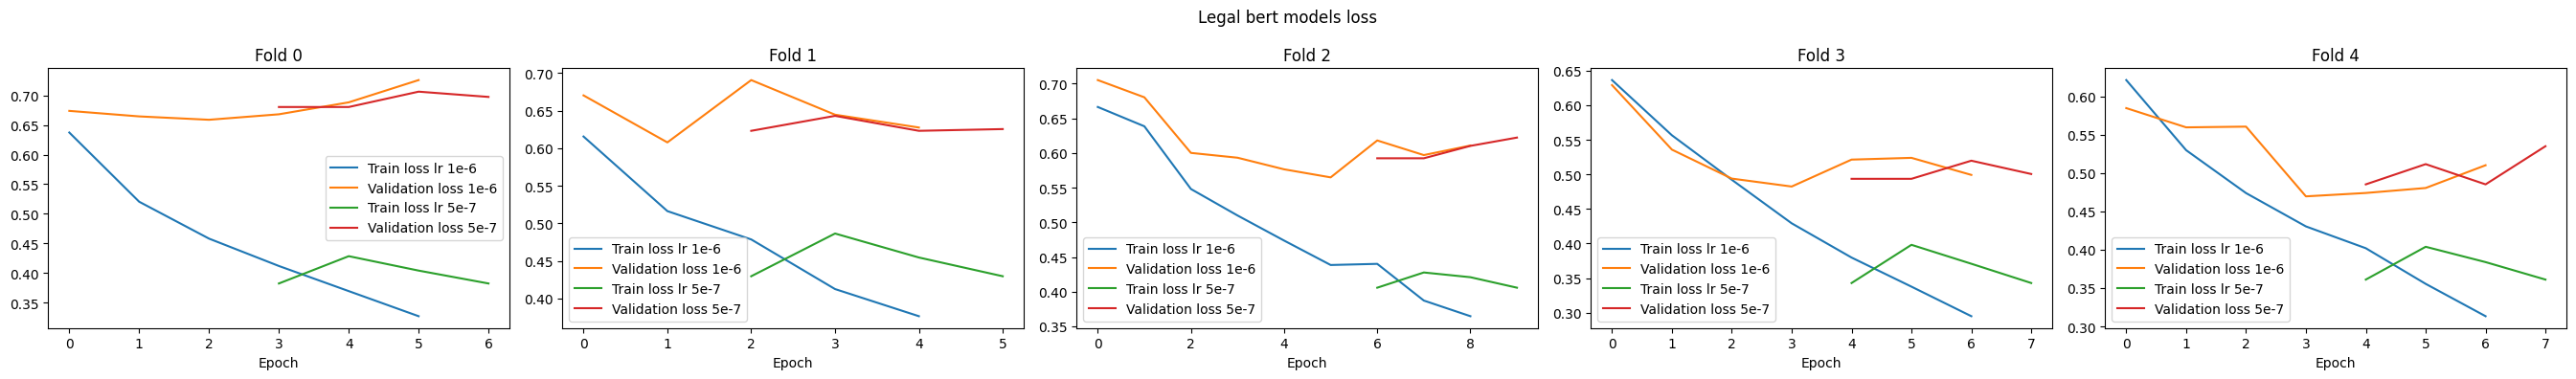

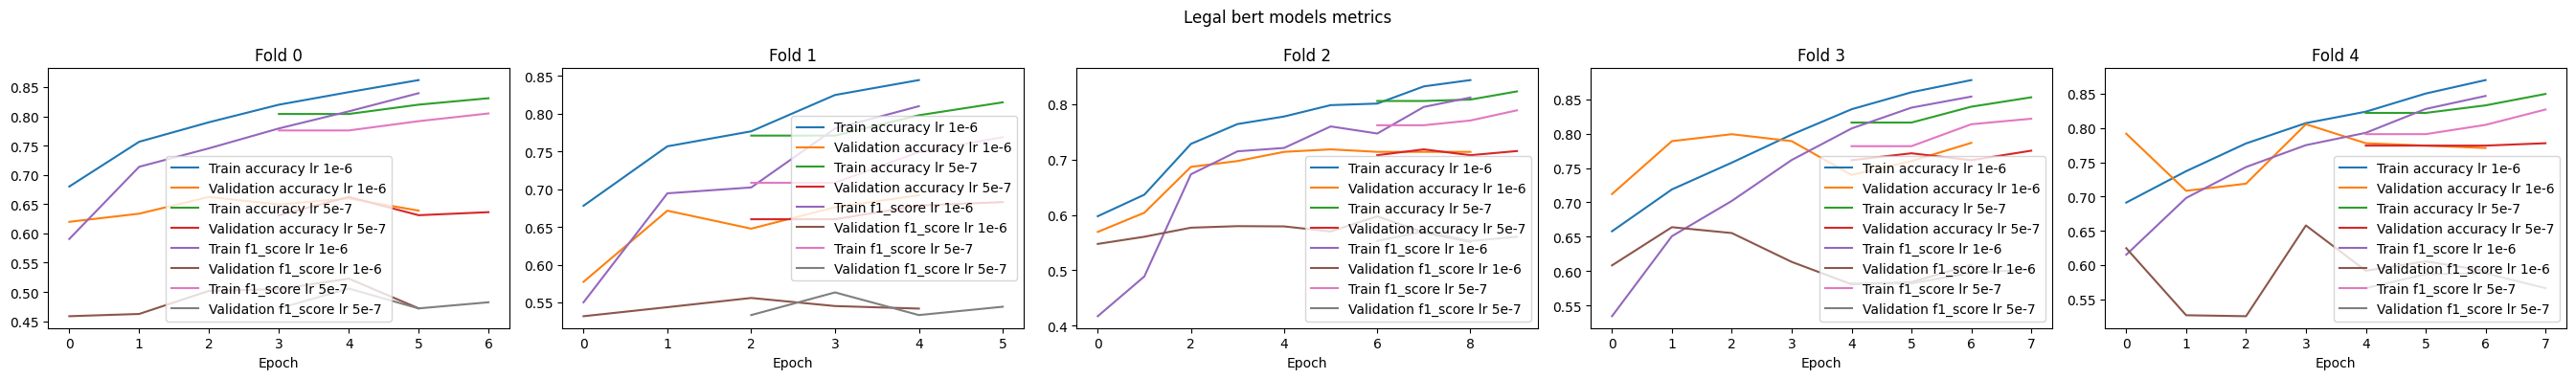

In [47]:
fig, axs = plt.subplots(ncols = len(legal_bert_models), figsize=(27, 4)) 
lrs = ["1e-6", "5e-7"]
for fold, train_data in enumerate(legal_bert_models):
    temp_list = [t["loss"] for t in train_data["data"]["train"]]
    train_metric = temp_list
    for i in range(1, len(train_metric)):
        train_metric[i] = [min(train_metric[-1])] + train_metric[i]
    temp_list = [t["loss"] for t in train_data["data"]["val"]]
    val_metric = temp_list
    for i in range(1, len(val_metric)):
        val_metric[i] = [min(val_metric[-1])] + val_metric[i]
    prev = 0
    for i in range(len(train_metric)):
        if i > 0:
            prev = len(train_metric[i - 1]) - 3
        axs[fold].plot([prev + j for j in range(len(train_metric[i]))], train_metric[i], label=f"Train loss lr {lrs[i]}")
        axs[fold].plot([prev + j for j in range(len(val_metric[i]))], val_metric[i], label=f"Validation loss {lrs[i]}")
    axs[fold].set_title(f"Fold {fold}")
    axs[fold].set_xlabel("Epoch")
    axs[fold].legend()
fig.suptitle("Legal bert models loss")
plt.tight_layout()
plt.savefig("Imgs/loss_legal_61.pdf", format="pdf")
plt.show()
fig, axs = plt.subplots(ncols = len(legal_bert_models), figsize=(27, 4)) 
for fold, train_data in enumerate(legal_bert_models):
    for metric in ["accuracy", "f1_score"]:
        temp_list = [t[metric] for t in train_data["data"]["train"]]
        train_metric = temp_list
        for i in range(1, len(train_metric)):
            train_metric[i] = [min(train_metric[-1])] + train_metric[i]
        temp_list = [t[metric] for t in train_data["data"]["val"]]
        val_metric = temp_list
        for i in range(1, len(val_metric)):
            val_metric[i] = [min(val_metric[-1])] + val_metric[i]
        prev = 0
        for i in range(len(train_metric)):
            if i > 0:
                prev = len(train_metric[i - 1]) - 3
            axs[fold].plot([prev + j for j in range(len(train_metric[i]))], train_metric[i], label=f"Train {metric} lr {lrs[i]}")
            axs[fold].plot([prev + j for j in range(len(val_metric[i]))], val_metric[i], label=f"Validation {metric} lr {lrs[i]}")
            axs[fold].set_title(f"Fold {fold}")
            axs[fold].set_xlabel("Epoch")
            axs[fold].legend()
fig.suptitle("Legal bert models metrics")
plt.tight_layout()
plt.savefig("Imgs/metrics_legal_61.pdf", format="pdf")
plt.show()

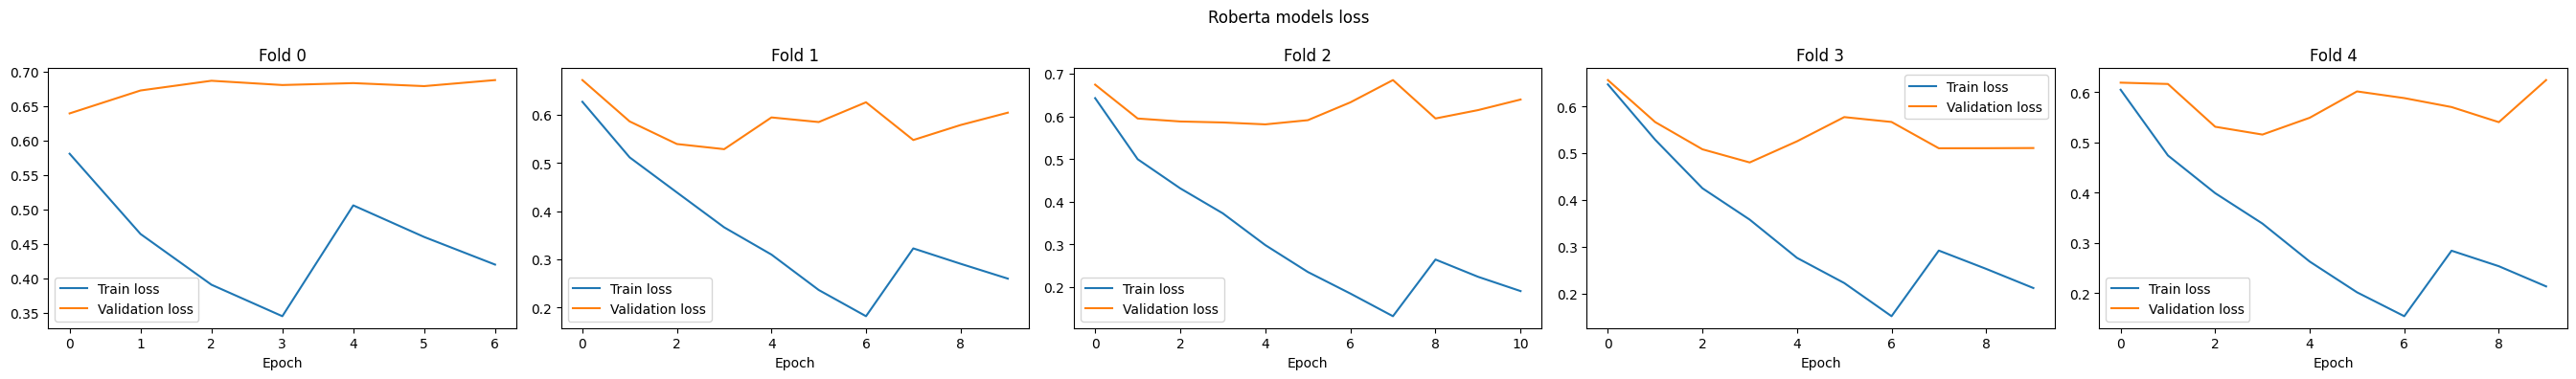

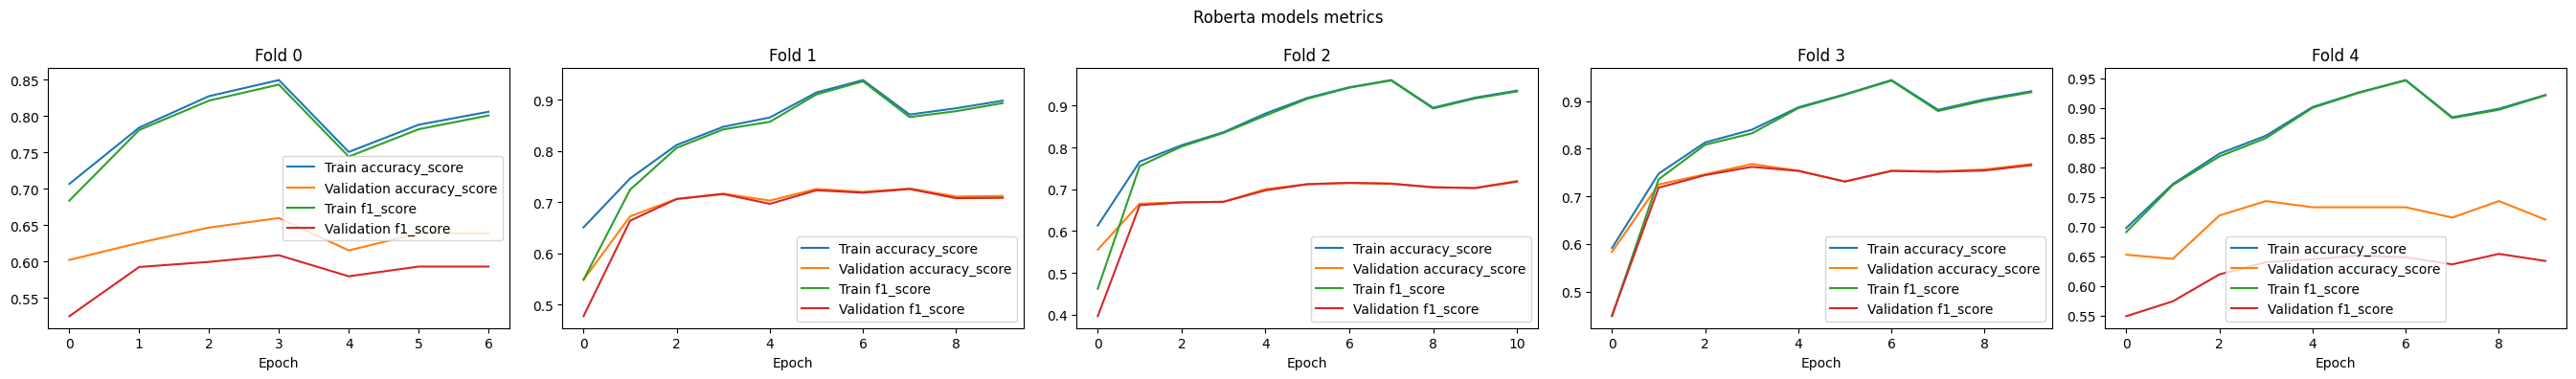

In [68]:
fig, axs = plt.subplots(ncols = len(roberta_models), figsize=(27, 4)) 
for fold, train_data in enumerate(roberta_models):
    temp_list = [t["loss"] for t in train_data["data"]["train"]]
    train_metric = []
    for l in temp_list:
        train_metric += l
    temp_list = [t["loss"] for t in train_data["data"]["val"]]
    val_metric = []
    for l in temp_list:
        val_metric += l
    x = [i for i in range(len(val_metric))]
    axs[fold].plot(x, train_metric, label="Train loss")
    axs[fold].plot(x, val_metric, label="Validation loss")
    axs[fold].set_title(f"Fold {fold}")
    axs[fold].set_xlabel("Epoch")
    axs[fold].legend()
fig.suptitle("Roberta models loss")
plt.tight_layout()
plt.savefig("Imgs/loss_roberta_61.pdf", format="pdf")
plt.show()
fig, axs = plt.subplots(ncols = len(roberta_models), figsize=(27, 4)) 
for fold, train_data in enumerate(roberta_models):
    for metric in ["accuracy_score", "f1_score"]:
        temp_list = [t[metric] for t in train_data["data"]["train"]]
        train_metric = []
        for l in temp_list:
            train_metric += l
        temp_list = [t[metric] for t in train_data["data"]["val"]]
        val_metric = []
        for l in temp_list:
            val_metric += l
        x = [i for i in range(len(val_metric))]
        axs[fold].plot(x, train_metric, label=f"Train {metric}")
        axs[fold].plot(x, val_metric, label=f"Validation {metric}")
        axs[fold].set_title(f"Fold {fold}")
        axs[fold].set_xlabel("Epoch")
        axs[fold].legend()
fig.suptitle("Roberta models metrics")
plt.tight_layout()
plt.savefig("Imgs/metrics_roberta_61.pdf", format="pdf")
plt.show()

In [32]:
best_model_legal_bert = Model(2, LEGAL_BERT)
best_model_fold_legal_bert = max(legal_bert_models, key= lambda x: x["f1"]) 
best_model_legal_bert.load_state_dict(best_model_fold_legal_bert["model"].state_dict())
best_model_legal_bert = best_model_legal_bert.to(device)
best_model_legal_bert.eval()

best_model_roberta = Model(2, ROBERTA)
best_model_fold_roberta = max(roberta_models, key= lambda x: x["f1"]) 
best_model_roberta.load_state_dict(best_model_fold_roberta["model"].state_dict())
best_model_roberta = best_model_roberta.to(device)
best_model_roberta.eval();

In [21]:
def predict(x, model, tokenizer, device):
    tokenized_x = tokenizer(x,padding = True, truncation=True, return_tensors='pt')
    tokenized_x = {key: tokenized_x[key].to(device) for key in tokenized_x.keys()}
    pred = model(tokenized_x)
    # keys = list(tokenized_x.keys())
    # for k in keys:
    #     del tokenized_x[k]
    #     del tokenized_x
    return torch.max(pred, -1)[1].view(-1).cpu().tolist()[0]

In [22]:
def get_acr_test_dataloader(cases, tokenizer, batch_size=16):
    ACR_x = []
    ACR_y = []
    for case in cases:
        clauses = case["all_clauses"]
        args_set = set()
        for argument in case["arguments"]:
            if not argument["conclusion"] in args_set:
                ACR_x.append(clauses[argument["conclusion"]])
                ACR_y.append(torch.tensor([0.,1.]))
                args_set.add(argument["conclusion"])
            for premise in argument["premises"]:
                if not premise in args_set and clauses[premise]:
                    ACR_x.append(clauses[premise])
                    ACR_y.append(torch.tensor([0.,1.]))
                    args_set.add(premise)
        for clause_id in clauses.keys():
            if not clause_id in args_set and clauses[clause_id]:
                ACR_x.append(clauses[clause_id])
                ACR_y.append(torch.tensor([1.,0.]))
    
    ACR_x_tokenized = dict_lists_to_list_of_dicts(tokenizer(ACR_x, padding=True, truncation=True, return_tensors='pt'))
    dataset = Dataset(ACR_x_tokenized, ACR_y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [23]:
def full_test(model, cases, tokenizer, device):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for case in cases:
            clauses = case["all_clauses"]
            args_set = set()
            splitter = "AS TO THE LAW" if "AS TO THE LAW" in case["text"] else "THE LAW"
            law_section = case["text"].split(splitter)[1]
            for argument in case["arguments"]:
                if (argument["conclusion"] not in args_set) and (clauses[argument["conclusion"]] in law_section):
                    prediction = predict(clauses[argument["conclusion"]], model, tokenizer, device)
                    y_pred.append(prediction)
                    y_true.append(1)
                    args_set.add(argument["conclusion"])
                elif argument["conclusion"] not in args_set and clauses[argument["conclusion"]] not in law_section:
                    args_set.add(argument["conclusion"])
                    y_pred.append(0)
                    y_true.append(1)
                for premise in argument["premises"]:
                    if premise not in args_set and clauses[premise] in law_section:
                        prediction = predict(clauses[premise], model, tokenizer, device)
                        y_pred.append(prediction)
                        y_true.append(1)
                        args_set.add(premise)
                        
                    elif premise not in args_set and clauses[premise] not in law_section:
                        args_set.add(premise)
                        y_pred.append(0)
                        y_true.append(1)
            for clause_id in clauses.keys():
                if (not clause_id in args_set) and (clauses[clause_id] in law_section):
                    prediction = predict(clauses[clause_id], model, tokenizer, device)
                    y_pred.append(prediction)
                    y_true.append(0)
                    args_set.add(clause_id)
                    
                if (not clause_id in args_set) and (clauses[clause_id] not in law_section):
                    y_pred.append(0)
                    y_true.append(0)
    print(f"""accuracy: {accuracy_score(y_true, y_pred):.2f}
f1: {f1_score(y_true, y_pred):.2f}
precision: {precision_score(y_true, y_pred):.2f}
recall: {recall_score(y_true, y_pred):.2f}""")
    
loss_function = nn.CrossEntropyLoss()
print("Test legal bert (with trick):")
full_test(best_model_legal_bert, test_cases, tokenizer, device)
print()
print("Test legal bert (without trick):")
predictions, true_labels, _ = test_61(best_model_legal_bert, get_acr_test_dataloader(test_cases, tokenizer, batch_size=8), device, loss_function)
print(f"""accuracy: {accuracy_score(true_labels, predictions):.2f}
f1: {f1_score(true_labels, predictions):.2f}
precision: {precision_score(true_labels, predictions):.2f}
recall: {recall_score(true_labels, predictions):.2f}""")
print()

tokenizer = RobertaTokenizer.from_pretrained(ROBERTA)
print("Test roberta (with trick):")
full_test(best_model_roberta, test_cases, tokenizer, device)
print()
print("Test roberta (without trick):")
predictions, true_labels, _ = test_61(best_model_roberta, get_acr_test_dataloader(test_cases, tokenizer, batch_size=8), device, loss_function)
print(f"""accuracy: {accuracy_score(true_labels, predictions):.2f}
f1: {f1_score(true_labels, predictions):.2f}
precision: {precision_score(true_labels, predictions):.2f}
recall: {recall_score(true_labels, predictions):.2f}""")

Test legal bert (with trick):
accuracy: 0.83
f1: 0.74
precision: 0.73
recall: 0.76

Test legal bert (without trick):
accuracy: 0.66
f1: 0.60
precision: 0.49
recall: 0.76

Test roberta (with trick):
accuracy: 0.79
f1: 0.73
precision: 0.64
recall: 0.84

Test roberta (without trick):
accuracy: 0.57
f1: 0.54
precision: 0.41
recall: 0.78


# 6.2 Argument Relation Mining

In [16]:
def get_arm_dataloader(cases, tokenizer, batch_size=16, shuffle=False, verbose=True):
    args_set = set()    #Prepare ids of clauses that are parts of arguments
    for case in refactored_dataset: 
        for argument in case["arguments"]: 
            args_set.add(argument["conclusion"])
            for premise in argument["premises"]:
                args_set.add(premise)

    ARM_x = []
    ARM_y = []
    for case in cases:
        clause_pos={}
        for clause in case['all_clauses']:
            clause_pos[clause] = case['text'].find(case['all_clauses'][clause])
        sorted_clauses = sorted(clause_pos.items(), key=lambda kv: kv[1])

        for el1 in range(len(sorted_clauses)-1):
            if sorted_clauses[el1][0] in args_set:
                for el2 in sorted_clauses[el1+1:el1+6]:
                    if el2[0] in args_set:
                        ARM_x.append({'e1': case['all_clauses'][sorted_clauses[el1][0]], 'e2': case['all_clauses'][el2[0]]})
                        y = torch.tensor([1., 0.])
                        for arg in case['arguments']:
                            if sorted_clauses[el1][0] in arg['premises'] or sorted_clauses[el1][0] == arg['conclusion']:
                                if el2[0] in arg['premises'] or el2[0] == arg['conclusion']:
                                    y = torch.tensor([0., 1.])
                        ARM_y.append(y)
    firsts = [el["e1"] for el in ARM_x]
    seconds = [el["e2"] for el in ARM_x]
    firsts = tokenizer.batch_encode_plus(
    firsts,
    add_special_tokens=True,
    padding = True,
    truncation=True,
    return_tensors='pt'
    )
    seconds = tokenizer.batch_encode_plus(
    seconds,
    add_special_tokens=True,
    padding = True,
    truncation=True,
    return_tensors='pt'
    )
    firsts = dict_lists_to_list_of_dicts(firsts)
    seconds = dict_lists_to_list_of_dicts(seconds)
    ARM_x_tokenized = [{"e1": firsts[i], "e2": seconds[i]} for i in range(len(firsts))]
    dataset = Dataset(ARM_x_tokenized, ARM_y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_cases, validation_cases, test_cases = cases[0]

ARM_train_dataloader = get_arm_dataloader(train_cases, tokenizer, shuffle=True, batch_size=8)
ARM_validation_dataloder = get_arm_dataloader(validation_cases, tokenizer, batch_size=8)
ARM_test_dataloader = get_arm_dataloader(test_cases, tokenizer, batch_size=8)

## Train

Model1 analyzes the two input text separately and then concatenate the output to pass it to the final linear layer

Molel2 concatenates the input text and then produce a single output to pass to the final linear layer

In [17]:
class Model1(NeuralNetwork):
    def __init__(self, out_features:int, bert_type:str, dropout:float = .2) -> None:
        super().__init__()
        self.encoder = AutoModel.from_pretrained(bert_type)
        self.output_layer = nn.Linear(self.encoder.config.hidden_size * 2, out_features)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input):
        encoded_input_1, _ = self.encoder(**input["e1"], return_dict = False)
        encoded_input_2, _ = self.encoder(**input["e2"], return_dict = False)
        
        encoded_input_1 = torch.nn.functional.avg_pool1d(
            encoded_input_1.permute(0, 2, 1), 
            kernel_size=encoded_input_1.size(1)
        ).squeeze(2)
        encoded_input_2 = torch.nn.functional.avg_pool1d(
            encoded_input_2.permute(0, 2, 1), 
            kernel_size=encoded_input_2.size(1)
        ).squeeze(2)
        encoded_input = self.dropout(torch.cat((encoded_input_1, encoded_input_2), dim=1))
        if len(encoded_input.size()) != 2:
            print(encoded_input.size())
        return self.output_layer(encoded_input).float()
    
class Model2(NeuralNetwork):
    def __init__(self, out_features:int, bert_type:str, dropout:float = .3) -> None:
        super().__init__()
        self.encoder = AutoModel.from_pretrained(bert_type)
        self.output_layer = nn.Linear(self.encoder.config.hidden_size, out_features)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input):
        input = {key: torch.cat((input["e1"][key], input["e2"][key]), dim=1) for key in input["e1"].keys()}
        encoded_input, _ = self.encoder(**input, return_dict = False)
        encoded_input = self.dropout(encoded_input)
        encoded_input = torch.nn.functional.avg_pool1d(
            encoded_input.permute(0, 2, 1), 
            kernel_size=encoded_input.size(1)
        ).squeeze(2)
        if len(encoded_input.size()) != 2:
            print(encoded_input.size())
        return self.output_layer(encoded_input).float()
    

In [18]:
def test_62(model, dataset, device, loss_function):
    model = model.to(device)
    model.eval()
    predictions, true_labels, loss = [], [], []
    for _, (inputs, labels) in enumerate(dataset):
        inputs = to(inputs, device)
        with torch.no_grad():
                outputs = model(inputs)
        preds = outputs.argmax(dim=-1).cpu().tolist()
        loss.append(loss_function(outputs.cpu(), labels).tolist())
        labels = labels.argmax(dim=-1).tolist()
        predictions += preds
        true_labels += labels
        del inputs 
        del outputs
    return predictions, true_labels, loss

def train_loop_62(model, training_dataloader, validation_dataloader, lr, device, early_stop):
    model = model.to(device)
    loss_function = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(model.parameters(), lr)
    train_data = {"accuracy_score":[], "f1_score":[], "loss" : []}
    val_data = {"accuracy_score":[], "f1_score":[], "loss" : []}
    while True:
        batch_num =  int(len(training_dataloader.dataset) / training_dataloader.batch_size)
        for i, (x, y) in enumerate(training_dataloader):
            x = to(x, device)
            y = to(y, device)
            out = model(x)
            loss = loss_function(out, y)
            loss.backward()
            optim.step()
            optim.zero_grad()
            print(f"{i}/{batch_num}", end="\r")
        print()
        predictions, true_labels, losses = test_62(model, training_dataloader, device, loss_function)
        train_data["accuracy_score"].append(accuracy_score(true_labels, predictions))
        train_data["f1_score"].append(f1_score(true_labels, predictions, average="macro"))
        train_data["loss"].append(torch.mean(torch.Tensor(losses)))
        predictions, true_labels, losses = test_62(model, validation_dataloader, device, loss_function)
        val_data["accuracy_score"].append(accuracy_score(true_labels, predictions))
        val_data["f1_score"].append(f1_score(true_labels, predictions, average="macro"))
        val_data["loss"].append(torch.mean(torch.Tensor(losses)))
        print(f"""train:
    accuracy: {train_data["accuracy_score"][-1]:.2f} f1:{train_data["f1_score"][-1]:.2f} loss:{train_data["loss"][-1]:.3f}
validation:
    accuracy: {val_data["accuracy_score"][-1]:.2f} f1:{val_data["f1_score"][-1]:.2f} loss:{val_data["loss"][-1]:.3f}""") 
        res = early_stop(model, None, None, None, {"train": float(train_data["loss"][-1]), "validation": float(val_data["loss"][-1])})
        if res:
            print("early stopping")
            return train_data, val_data
        
def fold_training_62(cases, bert_type, min_lr, start_lr, lr_multiplier, model_class):
    best_models = []
    if bert_type == ROBERTA:
        tokenizer = RobertaTokenizer.from_pretrained(bert_type)
    else:
        tokenizer = AutoTokenizer.from_pretrained(bert_type)
    for cases_split in cases:
        train_cases, validation_cases, _ = cases_split
        train_dataloader = get_arm_dataloader(train_cases, tokenizer, shuffle=True, batch_size=8, verbose=False)
        validation_dataloder = get_arm_dataloader(validation_cases, tokenizer, batch_size=8, verbose=False)
        model = model_class(2, bert_type)
        early_stopping = EarlyStopping(.001, 3, {"out_features": 2, "bert_type": bert_type}, model_class)
        train_data_fold, val_data_fold = train_62(model, train_dataloader, validation_dataloder, min_lr, start_lr, early_stopping, lr_multiplier)
        model.load_state_dict(early_stopping.best_model.state_dict())
        model = model.to("cpu")
        best_models.append({"loss": early_stopping.best_valid_loss, "model": model, "data":{"train": train_data_fold, "val":val_data_fold }})
        del early_stopping.best_model
        del early_stopping
        torch.cuda.empty_cache()
    
    return best_models

def train_62(model, train, validation, min_lr, start_lr, early_stopping, frac):
    tot_train_data, tot_val_data = [], []
    lr = start_lr
    while lr > min_lr:
        print(f'learning rate = {lr}')
        train_data, validation_data = train_loop_62(model, train, validation, lr, device, early_stopping)
        train_data["epochs"] = early_stopping.epochs
        train_data["lr"] = lr
        validation_data["epochs"] = early_stopping.epochs
        validation_data["lr"] = lr
        tot_train_data.append(train_data)
        tot_val_data.append(validation_data)
        model.load_state_dict(early_stopping.best_model.state_dict())
        lr = lr * frac
        early_stopping.reset()
    early_stopping.best_model = early_stopping.best_model.to("cpu")
    return tot_train_data, tot_val_data

In [19]:
legal_bert_models_model_1 = fold_training_62(cases, LEGAL_BERT, 5e-7, 1e-6, .6, Model1)

learning rate = 1e-06
880/880
train:
    accuracy: 0.65 f1:0.56 loss:0.630
validation:
    accuracy: 0.77 f1:0.48 loss:0.552
880/880
train:
    accuracy: 0.70 f1:0.68 loss:0.579
validation:
    accuracy: 0.74 f1:0.54 loss:0.546
880/880
train:
    accuracy: 0.75 f1:0.74 loss:0.515
validation:
    accuracy: 0.71 f1:0.56 loss:0.549
880/880
train:
    accuracy: 0.78 f1:0.77 loss:0.465
validation:
    accuracy: 0.68 f1:0.55 loss:0.575
880/880
train:
    accuracy: 0.82 f1:0.80 loss:0.421
validation:
    accuracy: 0.70 f1:0.56 loss:0.568
early stopping
learning rate = 6e-07
880/880
train:
    accuracy: 0.73 f1:0.71 loss:0.544
validation:
    accuracy: 0.72 f1:0.56 loss:0.551
880/880
train:
    accuracy: 0.75 f1:0.73 loss:0.509
validation:
    accuracy: 0.72 f1:0.54 loss:0.542
880/880
train:
    accuracy: 0.78 f1:0.76 loss:0.478
validation:
    accuracy: 0.71 f1:0.56 loss:0.552
880/880
train:
    accuracy: 0.79 f1:0.77 loss:0.457
validation:
    accuracy: 0.73 f1:0.54 loss:0.542
880/880
train:

In [20]:
for i, model_data in enumerate(legal_bert_models_model_1):
    f = open(f"trainings/6.2/legal_bert_m1_fold_{i}.json","w")
    for data in model_data["data"]["train"]:
        data["loss"] = [float(l) for l in data["loss"]]
    for data in model_data["data"]["val"]:
        data["loss"] = [float(l) for l in data["loss"]]
    json.dump(model_data["data"], f)
    f.close()
for i, model_info in enumerate(legal_bert_models_model_1):
    torch.save(model_info["model"].state_dict(), f"weights/6.2/best_model_legal_bert_m1_fold_{i}")

In [62]:
legal_bert_models_model_2 = fold_training_62(cases, LEGAL_BERT, 5e-7, 1e-6, .6, Model2)

learning rate = 1e-06
880/880
train:
    accuracy: 0.66 f1:0.58 loss:0.616
validation:
    accuracy: 0.76 f1:0.47 loss:0.559
880/880
train:
    accuracy: 0.72 f1:0.69 loss:0.551
validation:
    accuracy: 0.76 f1:0.52 loss:0.526
880/880
train:
    accuracy: 0.77 f1:0.76 loss:0.476
validation:
    accuracy: 0.76 f1:0.55 loss:0.510
880/880
train:
    accuracy: 0.81 f1:0.80 loss:0.417
validation:
    accuracy: 0.76 f1:0.57 loss:0.512
880/880
train:
    accuracy: 0.84 f1:0.83 loss:0.367
validation:
    accuracy: 0.78 f1:0.57 loss:0.512
880/880
train:
    accuracy: 0.85 f1:0.84 loss:0.329
validation:
    accuracy: 0.77 f1:0.59 loss:0.520
early stopping
learning rate = 6e-07
880/880
train:
    accuracy: 0.79 f1:0.77 loss:0.439
validation:
    accuracy: 0.77 f1:0.55 loss:0.505
880/880
train:
    accuracy: 0.81 f1:0.80 loss:0.406
validation:
    accuracy: 0.76 f1:0.58 loss:0.514
880/880
train:
    accuracy: 0.83 f1:0.82 loss:0.378
validation:
    accuracy: 0.77 f1:0.58 loss:0.517
880/880
train:

In [63]:
for i, model_data in enumerate(legal_bert_models_model_2):
    f = open(f"trainings/6.2/legal_bert_m2_fold_{i}.json","w")
    for data in model_data["data"]["train"]:
        data["loss"] = [float(l) for l in data["loss"]]
    for data in model_data["data"]["val"]:
        data["loss"] = [float(l) for l in data["loss"]]
    json.dump(model_data["data"], f)
    f.close()
for i, model_info in enumerate(legal_bert_models_model_2):
    torch.save(model_info["model"].state_dict(), f"weights/6.2/best_model_legal_bert_m2_fold_{i}")
    model_info["model"] = model_info["model"].to("cpu")

In [19]:
roberta_models_m1 = fold_training_62(cases, ROBERTA, 2e-6, 6e-6, .6, Model1)

learning rate = 6e-06
880/880
train:
    accuracy: 0.72 f1:0.67 loss:0.539
validation:
    accuracy: 0.77 f1:0.52 loss:0.511
880/880
train:
    accuracy: 0.83 f1:0.81 loss:0.401
validation:
    accuracy: 0.74 f1:0.55 loss:0.551
880/880
train:
    accuracy: 0.84 f1:0.83 loss:0.361
validation:
    accuracy: 0.71 f1:0.57 loss:0.570
880/880
train:
    accuracy: 0.86 f1:0.85 loss:0.313
validation:
    accuracy: 0.67 f1:0.57 loss:0.619
early stopping
learning rate = 3.6e-06
880/880
train:
    accuracy: 0.82 f1:0.81 loss:0.394
validation:
    accuracy: 0.70 f1:0.53 loss:0.556
880/880
train:
    accuracy: 0.85 f1:0.84 loss:0.347
validation:
    accuracy: 0.72 f1:0.54 loss:0.562
880/880
train:
    accuracy: 0.86 f1:0.85 loss:0.322
validation:
    accuracy: 0.73 f1:0.57 loss:0.573
early stopping
learning rate = 2.1599999999999996e-06
880/880
train:
    accuracy: 0.82 f1:0.81 loss:0.411
validation:
    accuracy: 0.73 f1:0.56 loss:0.543
880/880
train:
    accuracy: 0.84 f1:0.83 loss:0.361
validati

In [20]:
for i, model_data in enumerate(roberta_models_m1):
    f = open(f"trainings/6.2/roberta_m1_fold_{i}.json","w")
    for data in model_data["data"]["train"]:
        data["loss"] = [float(l) for l in data["loss"]]
    for data in model_data["data"]["val"]:
        data["loss"] = [float(l) for l in data["loss"]]
    json.dump(model_data["data"], f)
    f.close()
for i, model_info in enumerate(roberta_models_m1):
    torch.save(model_info["model"].state_dict(), f"weights/6.2/best_model_roberta_m1_fold_{i}")
    model_info["model"] = model_info["model"].to("cpu")

In [21]:
roberta_models_m2 = fold_training_62(cases, ROBERTA, 2e-6, 6e-6, .6, Model2)

learning rate = 6e-06
880/880
train:
    accuracy: 0.74 f1:0.69 loss:0.520
validation:
    accuracy: 0.77 f1:0.51 loss:0.503
880/880
train:
    accuracy: 0.83 f1:0.81 loss:0.373
validation:
    accuracy: 0.77 f1:0.54 loss:0.494
880/880
train:
    accuracy: 0.87 f1:0.86 loss:0.285
validation:
    accuracy: 0.75 f1:0.55 loss:0.505
880/880
train:
    accuracy: 0.88 f1:0.87 loss:0.232
validation:
    accuracy: 0.76 f1:0.54 loss:0.577
880/880
train:
    accuracy: 0.89 f1:0.88 loss:0.212
validation:
    accuracy: 0.75 f1:0.57 loss:0.575
early stopping
learning rate = 3.6e-06
880/880
train:
    accuracy: 0.87 f1:0.86 loss:0.269
validation:
    accuracy: 0.75 f1:0.56 loss:0.520
880/880
train:
    accuracy: 0.90 f1:0.89 loss:0.221
validation:
    accuracy: 0.74 f1:0.62 loss:0.583
880/880
train:
    accuracy: 0.90 f1:0.90 loss:0.189
validation:
    accuracy: 0.74 f1:0.62 loss:0.622
early stopping
learning rate = 2.1599999999999996e-06
880/880
train:
    accuracy: 0.87 f1:0.86 loss:0.272
validati

In [22]:
for i, model_data in enumerate(roberta_models_m2):
    f = open(f"trainings/6.2/roberta_m2_fold_{i}.json","w")
    for data in model_data["data"]["train"]:
        data["loss"] = [float(l) for l in data["loss"]]
    for data in model_data["data"]["val"]:
        data["loss"] = [float(l) for l in data["loss"]]
    json.dump(model_data["data"], f)
    f.close()
for i, model_info in enumerate(roberta_models_m2):
    torch.save(model_info["model"].state_dict(), f"weights/6.2/best_model_roberta_m2_fold_{i}")
    model_info["model"] = model_info["model"].to("cpu")

## Testing

### Training Curves 

Legal Bert Model 1:

In [78]:
legal_bert_models_model_1 = []
for fold in range(5):
    f = open(f"trainings/6.2/legal_bert_m1_fold_{fold}.json")
    data = json.load(f)
    model = Model1(2, LEGAL_BERT)
    model.load_state_dict(torch.load(f"weights/6.2/best_model_legal_bert_m1_fold_{fold}"))
    losses = [train["loss"] for train in data["val"]]
    f1s = [train["f1_score"] for train in data["val"]]
    loss = []
    f1 = []
    for l in losses:
        loss += l
    for f in f1s:
        f1 += f
    min_loss = min(loss)
    min_f1 = f1[loss.index(min_loss)]
    legal_bert_models_model_1.append({"loss": loss, "data":data, "model": model, 'f1': min_f1})
print('f1 scores for each fold:', [i['f1'] for i in legal_bert_models_model_1])
print('best fold:', np.argmax([i['f1'] for i in legal_bert_models_model_1]))

[0.5403440663774073, 0.5863899730902566, 0.6183366395988004, 0.6119188088214637, 0.6083600075315383]


Legal bert models m1:


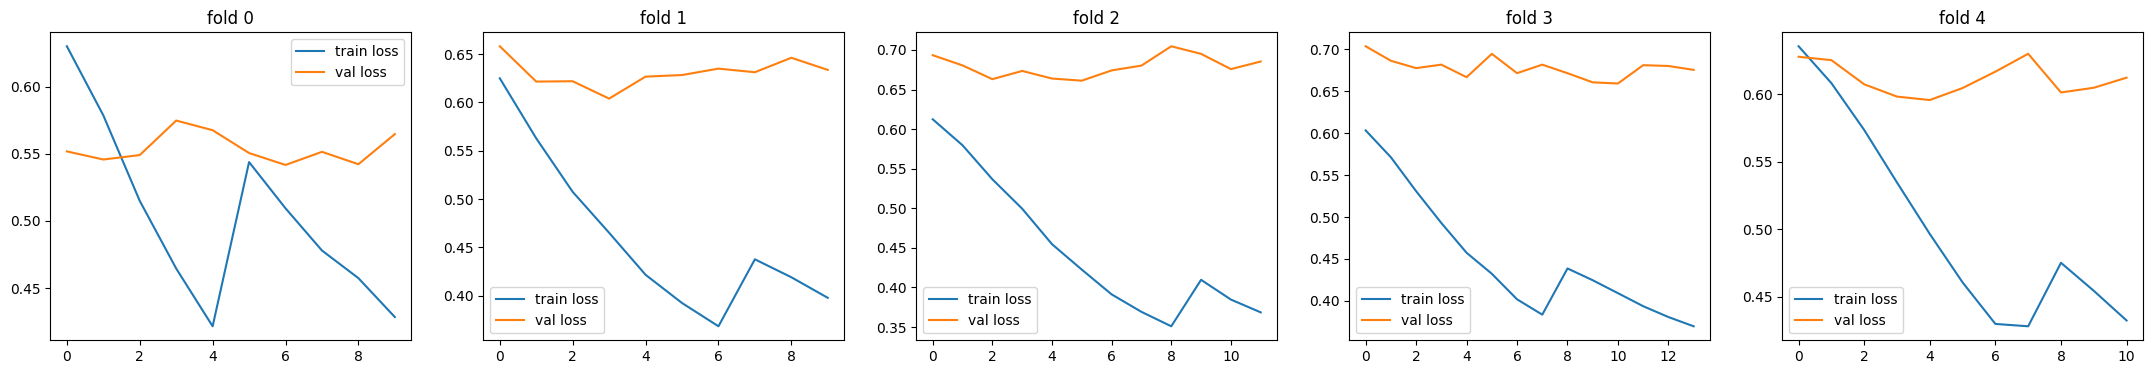

0.5642841709747628
0.6019997256154396
0.6183366395988004
0.6119188088214637
0.6083600075315383


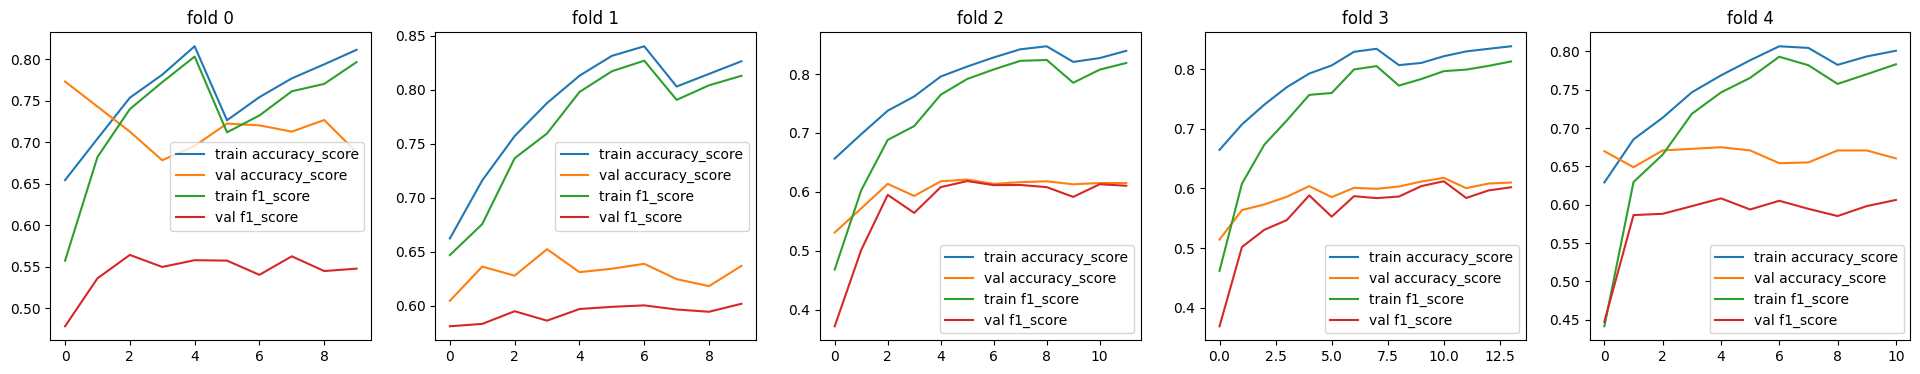

In [31]:
_, axs = plt.subplots(ncols = len(legal_bert_models_model_1), figsize=(27, 4)) 
for fold, train_data in enumerate(legal_bert_models_model_1):
    temp_list = [t["loss"] for t in train_data["data"]["train"]]
    train_metric = []
    for l in temp_list:
        train_metric += l
    temp_list = [t["loss"] for t in train_data["data"]["val"]]
    val_metric = []
    for l in temp_list:
        val_metric += l
    x = [i for i in range(len(val_metric))]
    axs[fold].plot(x, train_metric, label="train loss")
    axs[fold].plot(x, val_metric, label="val loss")
    axs[fold].set_title(f"fold {fold}")
    axs[fold].legend()
print("Legal bert models m1:")
plt.show()
_, axs = plt.subplots(ncols = len(legal_bert_models_model_1), figsize=(24, 4)) 
for fold, train_data in enumerate(legal_bert_models_model_1):
    for metric in ["accuracy_score", "f1_score"]:
        temp_list = [t[metric] for t in train_data["data"]["train"]]
        train_metric = []
        for l in temp_list:
            train_metric += l
        temp_list = [t[metric] for t in train_data["data"]["val"]]
        val_metric = []
        for l in temp_list:
            val_metric += l
        x = [i for i in range(len(val_metric))]
        axs[fold].plot(x, train_metric, label=f"train {metric}")
        axs[fold].plot(x, val_metric, label=f"val {metric}")
        axs[fold].set_title(f"fold {fold}")
        axs[fold].legend()
        if metric == 'f1_score':
            print(max(val_metric))
plt.show()

In [72]:
legal_bert_models_model_2 = []
for fold in range(5):
    f = open(f"trainings/6.2/legal_bert_m2_fold_{fold}.json")
    data = json.load(f)
    model = Model2(2, LEGAL_BERT)
    model.load_state_dict(torch.load(f"weights/6.2/best_model_legal_bert_m2_fold_{fold}"))
    losses = [train["loss"] for train in data["val"]]
    f1s = [train["f1_score"] for train in data["val"]]
    loss = []
    f1 = []
    for l in losses:
        loss += l
    for f in f1s:
        f1 += f
    min_loss = min(loss)
    min_f1 = f1[loss.index(min_loss)]
    legal_bert_models_model_2.append({"loss": min_loss, "data":data, "model": model, 'f1': min_f1})
print('f1 scores for each fold:', [i['f1'] for i in legal_bert_models_model_2])
print('best fold:', np.argmax([i['f1'] for i in legal_bert_models_model_2]))

[0.5536753323012865, 0.6121412921960825, 0.5617049432254759, 0.5647049478673872, 0.5319206266720559]


Legal bert models m2:


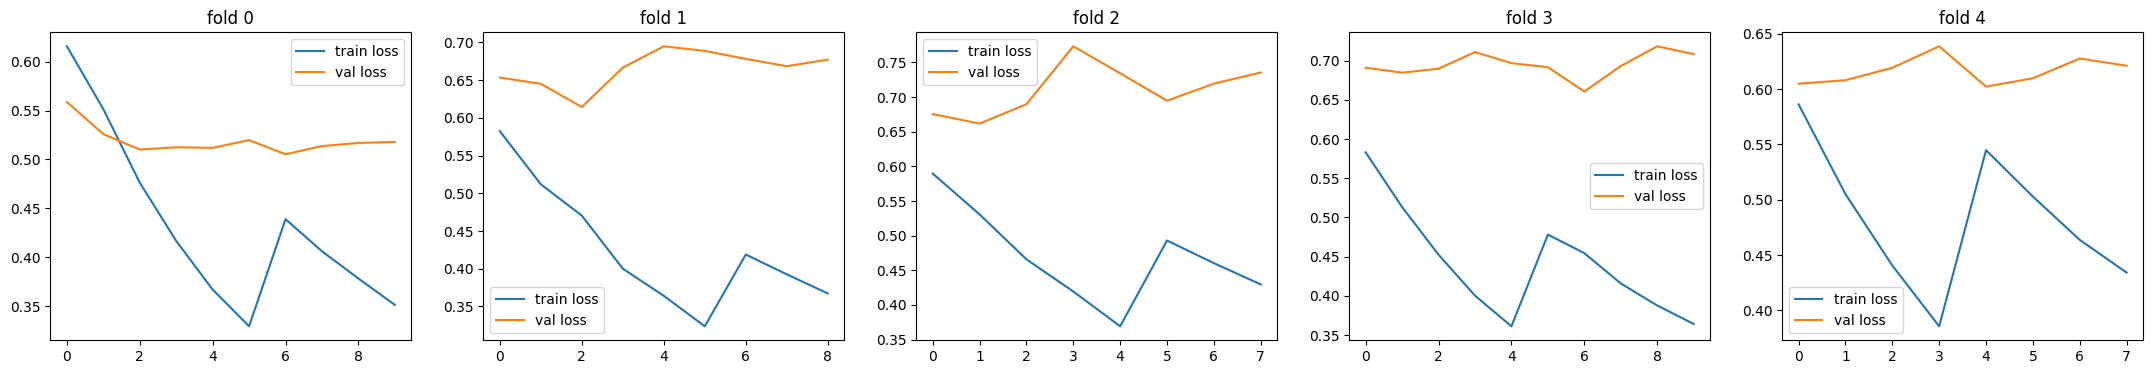

0.592278933680104
0.6121412921960825
0.5617049432254759
0.5647049478673872
0.5517468688200395


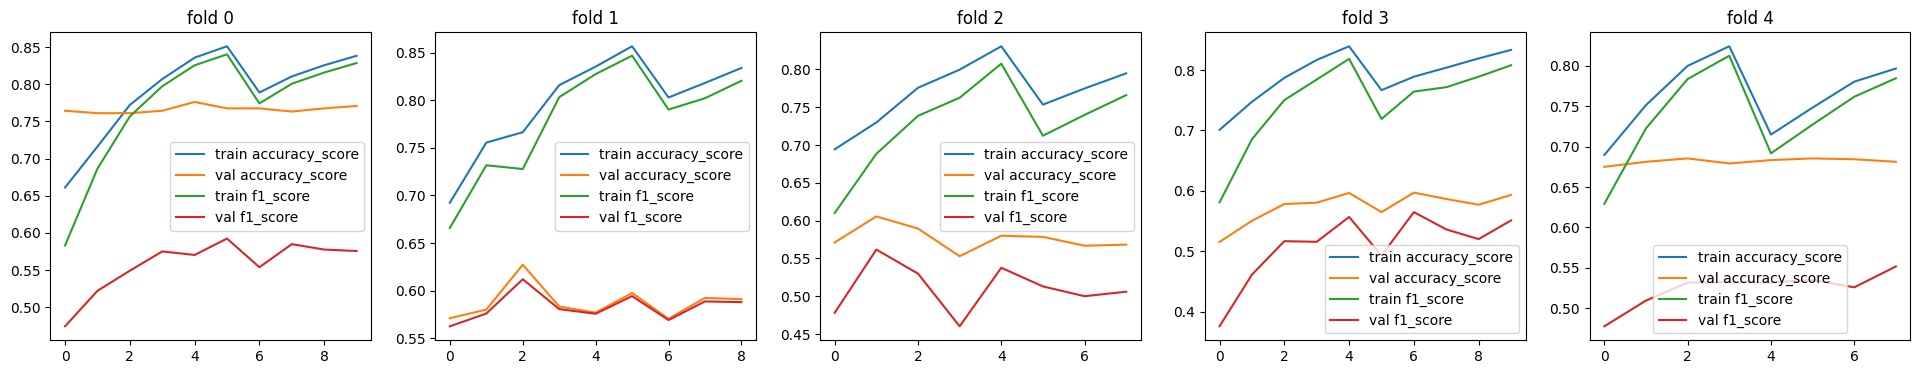

In [67]:
_, axs = plt.subplots(ncols = len(legal_bert_models_model_2), figsize=(27, 4)) 
for fold, train_data in enumerate(legal_bert_models_model_2): 
    temp_list = [t["loss"] for t in train_data["data"]["train"]]
    train_metric = []
    for l in temp_list:
        train_metric += l
    temp_list = [t["loss"] for t in train_data["data"]["val"]]
    val_metric = []
    for l in temp_list:
        val_metric += l
    x = [i for i in range(len(val_metric))]
    axs[fold].plot(x, train_metric, label="train loss")
    axs[fold].plot(x, val_metric, label="val loss")
    axs[fold].set_title(f"fold {fold}")
    axs[fold].legend()
print("Legal bert models m2:") 
plt.show()
_, axs = plt.subplots(ncols = len(legal_bert_models_model_2), figsize=(24, 4)) 
for fold, train_data in enumerate(legal_bert_models_model_2):
    for metric in ["accuracy_score", "f1_score"]:
        temp_list = [t[metric] for t in train_data["data"]["train"]]
        train_metric = []
        for l in temp_list:
            train_metric += l
        temp_list = [t[metric] for t in train_data["data"]["val"]]
        val_metric = []
        for l in temp_list:
            val_metric += l
        x = [i for i in range(len(val_metric))]
        axs[fold].plot(x, train_metric, label=f"train {metric}")
        axs[fold].plot(x, val_metric, label=f"val {metric}")
        axs[fold].set_title(f"fold {fold}")
        axs[fold].legend()
plt.show()

In [23]:
roberta_models_model_1 = []
for fold in range(5):
    f = open(f"trainings/6.2/roberta_m1_fold_{fold}.json")
    data = json.load(f)
    model = Model1(2, ROBERTA)
    model.load_state_dict(torch.load(f"weights/6.2/best_model_roberta_m1_fold_{fold}"))
    losses = [train["loss"] for train in data["val"]]
    f1s = [train["f1_score"] for train in data["val"]]
    loss = []
    f1 = []
    for l in losses:
        loss += l
    for f in f1s:
        f1 += f
    min_loss = min(loss)
    min_f1 = f1[loss.index(min_loss)]
    roberta_models_model_1.append({"loss": min_loss, "data":data, "model": model, 'f1': min_f1})
print('f1 scores for each fold:', [i['f1'] for i in roberta_models_model_1])
print('best fold:', np.argmax([i['f1'] for i in roberta_models_model_1]))


f1 scores for each fold: [0.5165923773244055, 0.5853177925784967, 0.6380078631266488, 0.6320151242794272, 0.6084386571167788]
best fold: 2


Roberta models m1:


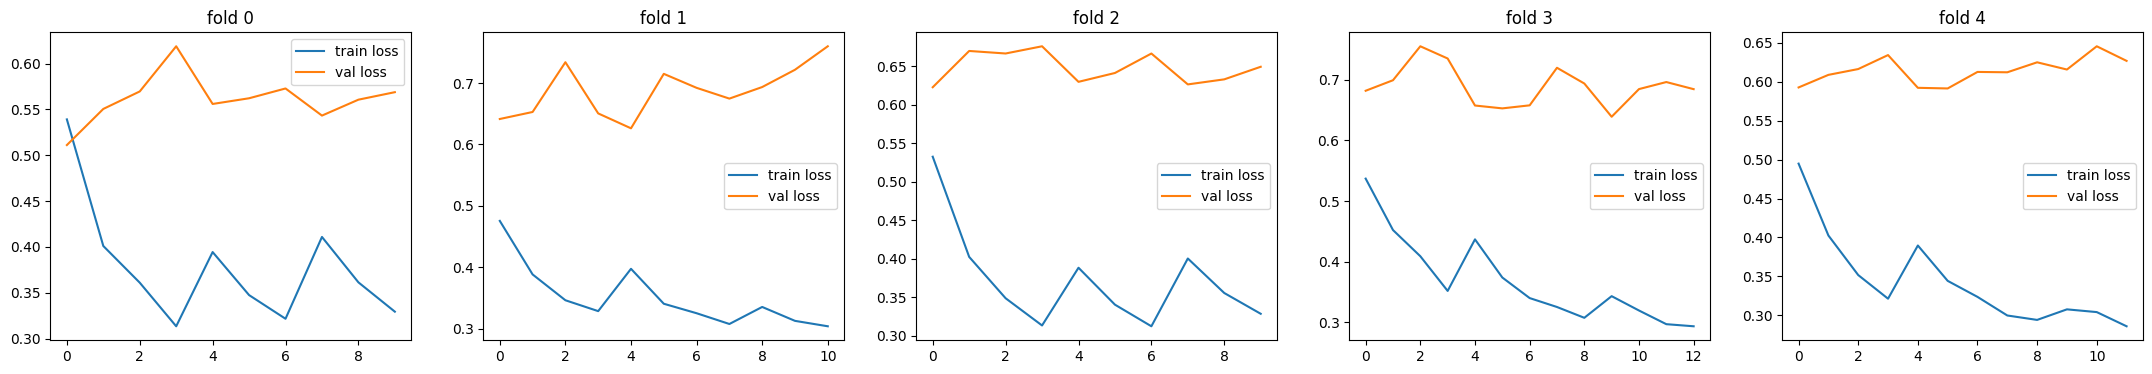

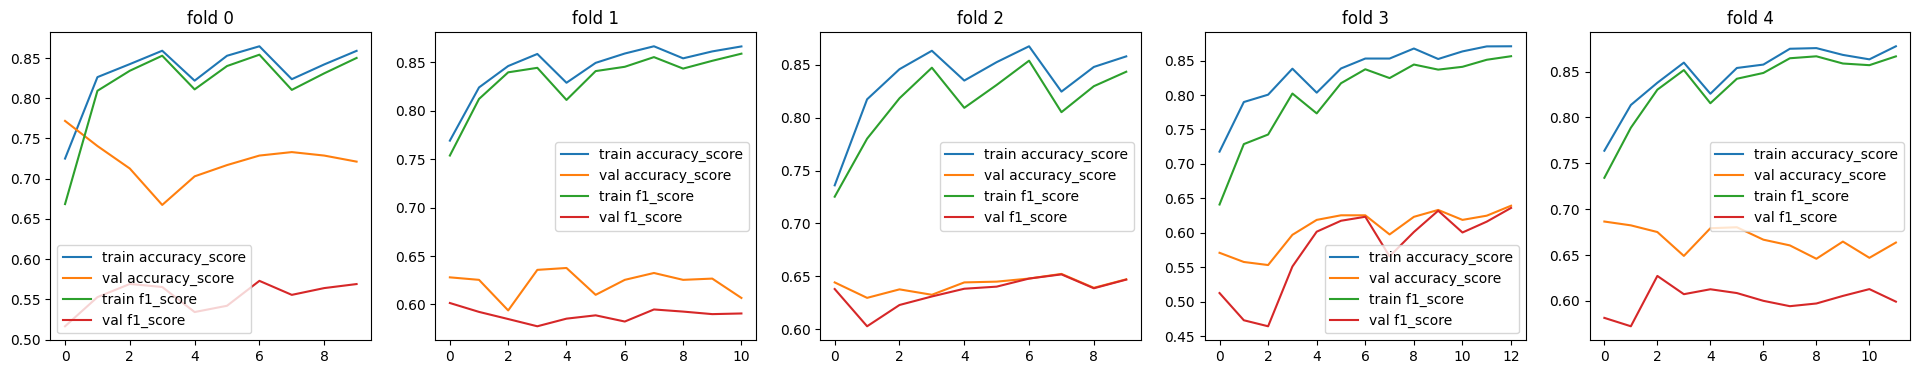

In [24]:
_, axs = plt.subplots(ncols = len(roberta_models_model_1), figsize=(27, 4))
for fold, train_data in enumerate(roberta_models_model_1):
    temp_list = [t["loss"] for t in train_data["data"]["train"]]
    train_metric = []
    for l in temp_list:
        train_metric += l
    temp_list = [t["loss"] for t in train_data["data"]["val"]]
    val_metric = []
    for l in temp_list:
        val_metric += l
    x = [i for i in range(len(val_metric))]
    axs[fold].plot(x, train_metric, label="train loss")
    axs[fold].plot(x, val_metric, label="val loss")
    axs[fold].set_title(f"fold {fold}")
    axs[fold].legend()
print("Roberta models m1:")
plt.show()
_, axs = plt.subplots(ncols = len(roberta_models_model_1), figsize=(24, 4))
for fold, train_data in enumerate(roberta_models_model_1):
    for metric in ["accuracy_score", "f1_score"]:
        temp_list = [t[metric] for t in train_data["data"]["train"]]
        train_metric = []
        for l in temp_list:
            train_metric += l
        temp_list = [t[metric] for t in train_data["data"]["val"]]
        val_metric = []
        for l in temp_list:
            val_metric += l
        x = [i for i in range(len(val_metric))]
        axs[fold].plot(x, train_metric, label=f"train {metric}")
        axs[fold].plot(x, val_metric, label=f"val {metric}")
        axs[fold].set_title(f"fold {fold}")
        axs[fold].legend()
plt.show()

In [25]:
roberta_models_model_2 = [] 
for fold in range(5):
    f = open(f"trainings/6.2/roberta_m2_fold_{fold}.json") 
    data = json.load(f)
    model = Model2(2, ROBERTA)
    model.load_state_dict(torch.load(f"weights/6.2/best_model_roberta_m2_fold_{fold}")) 
    losses = [train["loss"] for train in data["val"]]
    f1s = [train["f1_score"] for train in data["val"]]
    loss = []
    f1s = []
    for l in losses:
        loss += l
    for f in f1s:
        f1s += f
    min_loss = min(loss)
    min_f1 = f1[loss.index(min_loss)]
    roberta_models_model_2.append({"loss": min_loss, "data":data, "model": model, 'f1': min_f1})
print('f1 scores for each fold:', [i['f1'] for i in roberta_models_model_2])
print('best fold:', np.argmax([i['f1'] for i in roberta_models_model_2]))


f1 scores for each fold: [0.5721993889815044, 0.5721993889815044, 0.627121344912756, 0.5721993889815044, 0.5721993889815044]
best fold: 2


Roberta models m2:


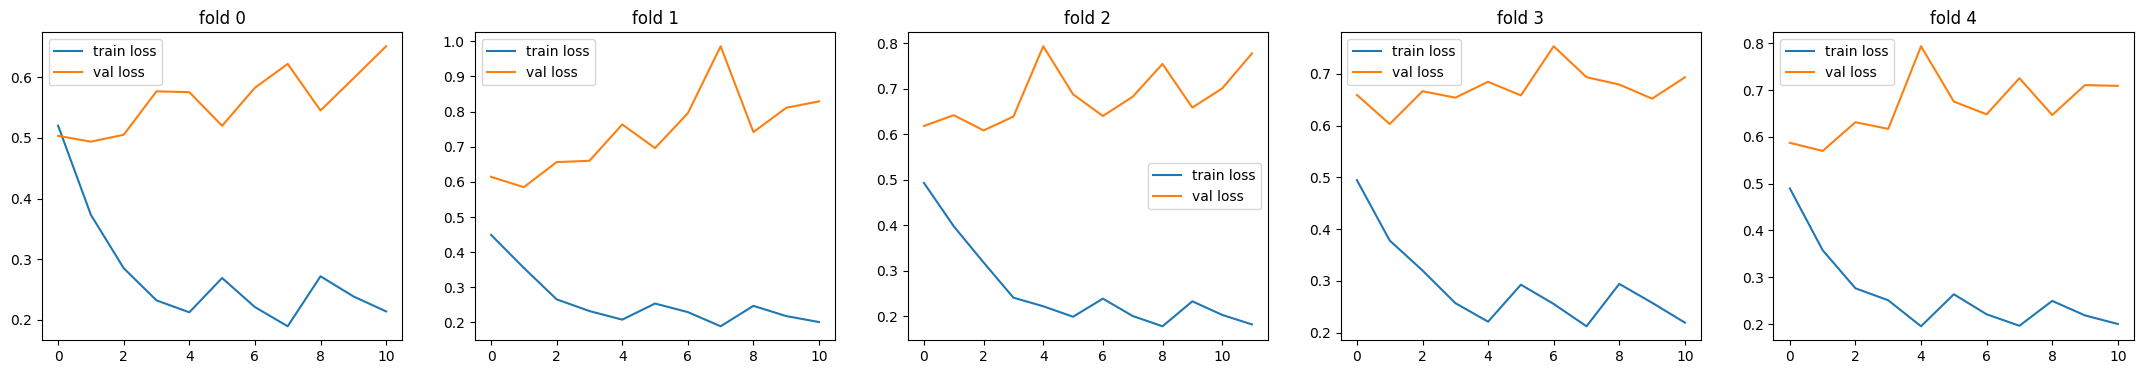

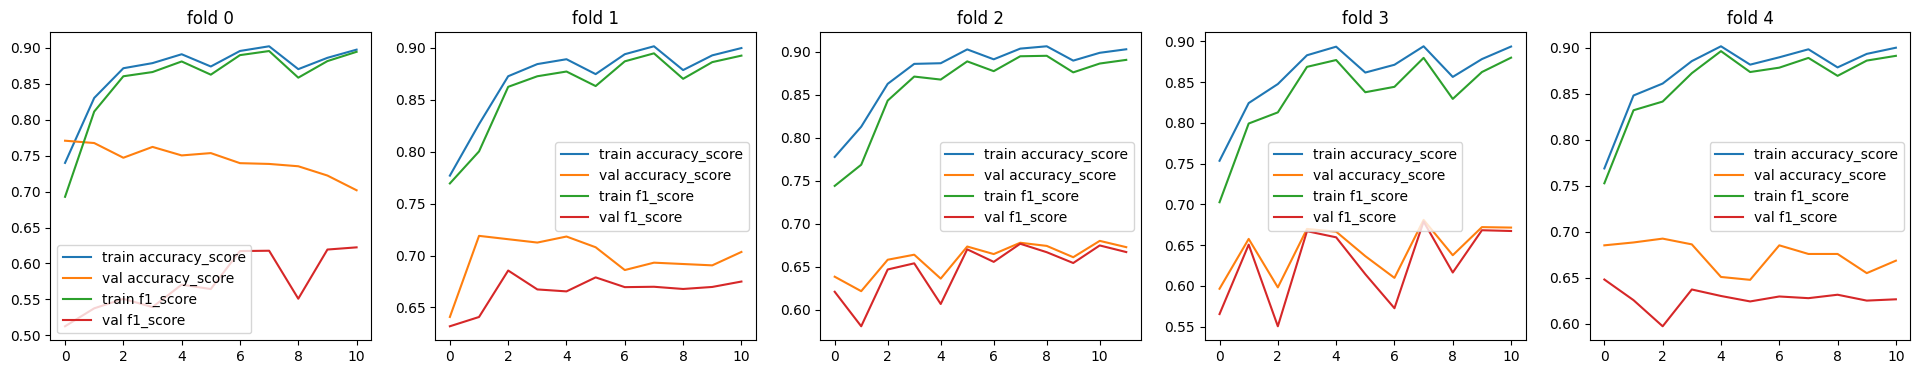

In [26]:
_, axs = plt.subplots(ncols = len(roberta_models_model_2), figsize=(27, 4)) 
for fold, train_data in enumerate(roberta_models_model_2): 
    temp_list = [t["loss"] for t in train_data["data"]["train"]]
    train_metric = []
    for l in temp_list:
        train_metric += l
    temp_list = [t["loss"] for t in train_data["data"]["val"]]
    val_metric = []
    for l in temp_list:
        val_metric += l
    x = [i for i in range(len(val_metric))]
    axs[fold].plot(x, train_metric, label="train loss")
    axs[fold].plot(x, val_metric, label="val loss")
    axs[fold].set_title(f"fold {fold}")
    axs[fold].legend()
print("Roberta models m2:") 
plt.show()
_, axs = plt.subplots(ncols = len(roberta_models_model_2), figsize=(24, 4)) 
for fold, train_data in enumerate(roberta_models_model_2):
    for metric in ["accuracy_score", "f1_score"]:
        temp_list = [t[metric] for t in train_data["data"]["train"]]
        train_metric = []
        for l in temp_list:
            train_metric += l
        temp_list = [t[metric] for t in train_data["data"]["val"]]
        val_metric = []
        for l in temp_list:
            val_metric += l
        x = [i for i in range(len(val_metric))]
        axs[fold].plot(x, train_metric, label=f"train {metric}")
        axs[fold].plot(x, val_metric, label=f"val {metric}")
        axs[fold].set_title(f"fold {fold}")
        axs[fold].legend()
plt.show()

# 6.3 Premise/Conclusion Recognition

In [18]:
#train_cases, validation_cases, test_cases = cases[-1]
def get_pcr_dataloader(cases, tokenizer, batch_size=16, shuffle=False, verbose=True):
    PCR_x = []
    PCR_y = []
    argdict = {}
    for case in cases:
        n_clauses = case["n_clauses"]
        clauses = case["all_clauses"]
        for argument in case["arguments"]:
            if not clauses[argument["conclusion"]] in argdict:
                argdict[clauses[argument["conclusion"]]] = [0.,1.]
            else:
                argdict[clauses[argument["conclusion"]]][1] = 1.

            for premise in argument["premises"]:
                if not clauses[premise] in argdict:
                    argdict[clauses[premise]] = [1.,0.]
                else:
                    argdict[clauses[premise]][0] = 1.

    items = list(argdict.items())
    for item in items:
        PCR_x.append(item[0])
        PCR_y.append(torch.tensor(item[1]))


    PCR_x_tokenized = dict_lists_to_list_of_dicts(tokenizer(PCR_x, padding=True, truncation=True, return_tensors='pt'))
    if verbose:
        print(f"""
    There are:
        - {len(PCR_x)} clauses
        - {len([a for a in PCR_y if a[0] == 1.])} premises
        - {len([a for a in PCR_y if a[1] == 1.])} conclusions
        """)
    
    dataset = Dataset(PCR_x_tokenized, PCR_y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

print("train set:")
PCR_train_dataloader = get_pcr_dataloader(train_cases, tokenizer, shuffle=True, batch_size=8)
print("validation set:")
PCR_validation_dataloader = get_pcr_dataloader(validation_cases, tokenizer, batch_size=8)
print("test set:")
PCR_test_dataloader = get_pcr_dataloader(test_cases, tokenizer, batch_size=8)

train set:

    There are:
        - 1607 clauses
        - 1279 premises
        - 451 conclusions
        
validation set:

    There are:
        - 199 clauses
        - 157 premises
        - 62 conclusions
        
test set:

    There are:
        - 561 clauses
        - 441 premises
        - 155 conclusions
        


### Training

In [19]:
def test_63(model, dataset, device, loss_function):
    model = model.to(device)
    model.eval()
    predictions, true_labels, loss = [], [], []
    for _, (inputs, labels) in enumerate(dataset):
        inputs = to(inputs, device)
        with torch.no_grad():
                outputs = model(inputs)
        preds = torch.round(nn.functional.sigmoid(outputs)).cpu().reshape(-1).tolist()
        loss.append(loss_function(outputs.cpu(), labels).tolist())
        labels = torch.round(nn.functional.sigmoid(labels)).cpu().reshape(-1).tolist()
        predictions += preds
        true_labels += labels
        del inputs 
        del outputs
    return predictions, true_labels, loss

def train_loop_63(model, training_dataloader, validation_dataloader, lr, device, early_stop):
    model = model.to(device)
    loss_function = nn.BCEWithLogitsLoss()
    optim = torch.optim.Adam(model.parameters(), lr)
    train_data = {"accuracy_score":[], "f1_score":[], "loss" : []}
    val_data = {"accuracy_score":[], "f1_score":[], "loss" : []}
    while True:
        batch_num =  int(len(training_dataloader.dataset) / training_dataloader.batch_size)
        for i, (x, y) in enumerate(training_dataloader):
            x = to(x, device)
            y = to(y, device)
            out = model(x)
            loss = loss_function(out, y)
            loss.backward()
            optim.step()
            optim.zero_grad()
            print(f"{i}/{batch_num}", end="\r")
        print()
        predictions, true_labels, losses = test_63(model, training_dataloader, device, loss_function)
        predictions = [1 - p for p in predictions]
        true_labels = [1 - t for t in true_labels]
        train_data["accuracy_score"].append(accuracy_score(true_labels, predictions))
        train_data["f1_score"].append(f1_score(true_labels, predictions, average="macro"))
        train_data["loss"].append(torch.mean(torch.Tensor(losses)))
        predictions, true_labels, losses = test_63(model, validation_dataloader, device, loss_function)
        predictions = [1 - p for p in predictions]
        true_labels = [1 - t for t in true_labels]
        val_data["accuracy_score"].append(accuracy_score(true_labels, predictions))
        val_data["f1_score"].append(f1_score(true_labels, predictions, average="macro"))
        val_data["loss"].append(torch.mean(torch.Tensor(losses)))
        print(f"""train:
    accuracy: {train_data["accuracy_score"][-1]:.2f} f1:{train_data["f1_score"][-1]:.2f} loss:{train_data["loss"][-1]:.3f}
validation:
    accuracy: {val_data["accuracy_score"][-1]:.2f} f1:{val_data["f1_score"][-1]:.2f} loss:{val_data["loss"][-1]:.3f}""") 
        res = early_stop(model, None, None, None, {"train": float(train_data["loss"][-1]), "validation": float(val_data["loss"][-1])})
        if res:
            print("early stopping")
            return train_data, val_data
        
def fold_training_63(cases, bert_type, min_lr, start_lr, lr_multiplier, get_dataloader, model_class):
    best_models = []
    if bert_type == ROBERTA:
        tokenizer = RobertaTokenizer.from_pretrained(bert_type)
    else:
        tokenizer = AutoTokenizer.from_pretrained(bert_type)
    for cases_split in cases:
        train_cases, validation_cases, _ = cases_split
        train_dataloader = get_dataloader(train_cases, tokenizer, shuffle=True, batch_size=8, verbose=False)
        validation_dataloder = get_dataloader(validation_cases, tokenizer, batch_size=8, verbose=False)
        model = model_class(2, bert_type)
        early_stopping = EarlyStopping(.001, 3, {"out_features": 2, "bert_type": bert_type}, model_class)
        train_data_fold, val_data_fold = train_63(model, train_dataloader, validation_dataloder, min_lr, start_lr, early_stopping, lr_multiplier)
        model.load_state_dict(early_stopping.best_model.state_dict())
        model = model.to("cpu")
        best_models.append({"loss": early_stopping.best_valid_loss, "model": model, "data":{"train": train_data_fold, "val":val_data_fold }})
        del early_stopping.best_model
        del early_stopping
        torch.cuda.empty_cache()
    
    return best_models

def train_63(model, train, validation, min_lr, start_lr, early_stopping, frac):
    tot_train_data, tot_val_data = [], []
    lr = start_lr
    while lr > min_lr:
        print(f'learning rate = {lr}')
        train_data, validation_data = train_loop_63(model, train, validation, lr, device, early_stopping)
        train_data["epochs"] = early_stopping.epochs
        train_data["lr"] = lr
        validation_data["epochs"] = early_stopping.epochs
        validation_data["lr"] = lr
        tot_train_data.append(train_data)
        tot_val_data.append(validation_data)
        model.load_state_dict(early_stopping.best_model.state_dict())
        lr = lr * frac
        early_stopping.reset()
    early_stopping.best_model = early_stopping.best_model.to("cpu")
    return tot_train_data, tot_val_data

In [20]:
class ModelPCR(NeuralNetwork):
    def __init__(self, out_features:int, bert_type:str, dropout:float = 0.2) -> None:
        super().__init__()
        if bert_type == ROBERTA:
            self.encoder = RobertaModel.from_pretrained(bert_type)
        else:     
            self.encoder = AutoModel.from_pretrained(bert_type)
        self.output_layer = nn.Linear(self.encoder.config.hidden_size, out_features)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input):
        encoded_input, _ = self.encoder(**input, return_dict = False)
        encoded_input = self.dropout(encoded_input)
        encoded_input = torch.nn.functional.avg_pool1d(
            encoded_input.permute(0, 2, 1), 
            kernel_size=encoded_input.size(1)
        ).squeeze(2)
        return self.output_layer(encoded_input).float()

    def freeze_bert(self):
        for param in self.encoder.parameters():
                param.requires_grad = False
    def unfreeze_bert(self):
        for param in self.encoder.parameters():
                param.requires_grad = True

In [21]:
legal_bert_models = fold_training_63(cases, LEGAL_BERT, 5e-7, 1e-6, .6, get_pcr_dataloader, ModelPCR)

learning rate = 1e-06
198/199
train:
    accuracy: 0.76 f1:0.76 loss:0.509
validation:
    accuracy: 0.71 f1:0.71 loss:0.592
198/199
train:
    accuracy: 0.80 f1:0.80 loss:0.429
validation:
    accuracy: 0.73 f1:0.73 loss:0.554
198/199
train:
    accuracy: 0.84 f1:0.84 loss:0.372
validation:
    accuracy: 0.75 f1:0.75 loss:0.519
198/199
train:
    accuracy: 0.86 f1:0.86 loss:0.329
validation:
    accuracy: 0.76 f1:0.76 loss:0.491
198/199
train:
    accuracy: 0.89 f1:0.89 loss:0.297
validation:
    accuracy: 0.78 f1:0.78 loss:0.477
198/199
train:
    accuracy: 0.90 f1:0.90 loss:0.270
validation:
    accuracy: 0.78 f1:0.78 loss:0.466
198/199
train:
    accuracy: 0.91 f1:0.91 loss:0.243
validation:
    accuracy: 0.79 f1:0.79 loss:0.477
198/199
train:
    accuracy: 0.93 f1:0.93 loss:0.218
validation:
    accuracy: 0.79 f1:0.79 loss:0.478
198/199
train:
    accuracy: 0.93 f1:0.93 loss:0.197
validation:
    accuracy: 0.80 f1:0.80 loss:0.493
early stopping
learning rate = 6e-07
198/199
train:

In [22]:
for i, model_data in enumerate(legal_bert_models):
    f = open(f"trainings/6.3/legal_bert_fold_{i}.json","w")
    for data in model_data["data"]["train"]:
        data["loss"] = [float(l) for l in data["loss"]]
    for data in model_data["data"]["val"]:
        data["loss"] = [float(l) for l in data["loss"]]
    json.dump(model_data["data"], f)
    f.close()
for i, model_info in enumerate(legal_bert_models):
    torch.save(model_info["model"].state_dict(), f"weights/6.3/best_model_legal_bert_fold_{i}")
    model_info["model"] = model_info["model"].to("cpu")

In [23]:
roberta_models = fold_training_63(cases, ROBERTA, 5e-7, 1e-6, .6, get_pcr_dataloader, ModelPCR)
for i, model_data in enumerate(roberta_models):
    f = open(f"trainings/6.3/roberta_fold_{i}.json","w")
    for data in model_data["data"]["train"]:
        data["loss"] = [float(l) for l in data["loss"]]
    for data in model_data["data"]["val"]:
        data["loss"] = [float(l) for l in data["loss"]]
    json.dump(model_data["data"], f)
    f.close()
for i, model_info in enumerate(roberta_models):
    torch.save(model_info["model"].state_dict(), f"weights/6.3/best_model_roberta_fold_{i}")
    model_info["model"] = model_info["model"].to("cpu")

learning rate = 1e-06
198/199
train:
    accuracy: 0.76 f1:0.76 loss:0.527
validation:
    accuracy: 0.71 f1:0.71 loss:0.586
198/199
train:
    accuracy: 0.81 f1:0.81 loss:0.398
validation:
    accuracy: 0.75 f1:0.75 loss:0.502
198/199
train:
    accuracy: 0.86 f1:0.86 loss:0.318
validation:
    accuracy: 0.78 f1:0.78 loss:0.473
198/199
train:
    accuracy: 0.89 f1:0.89 loss:0.283
validation:
    accuracy: 0.77 f1:0.77 loss:0.504
198/199
train:
    accuracy: 0.91 f1:0.91 loss:0.231
validation:
    accuracy: 0.78 f1:0.78 loss:0.512
198/199
train:
    accuracy: 0.93 f1:0.93 loss:0.204
validation:
    accuracy: 0.78 f1:0.78 loss:0.514
early stopping
learning rate = 6e-07
198/199
train:
    accuracy: 0.88 f1:0.88 loss:0.291
validation:
    accuracy: 0.78 f1:0.78 loss:0.489
198/199
train:
    accuracy: 0.89 f1:0.89 loss:0.264
validation:
    accuracy: 0.79 f1:0.78 loss:0.480
198/199
train:
    accuracy: 0.90 f1:0.90 loss:0.244
validation:
    accuracy: 0.79 f1:0.79 loss:0.500
early stopping

Roberta models:


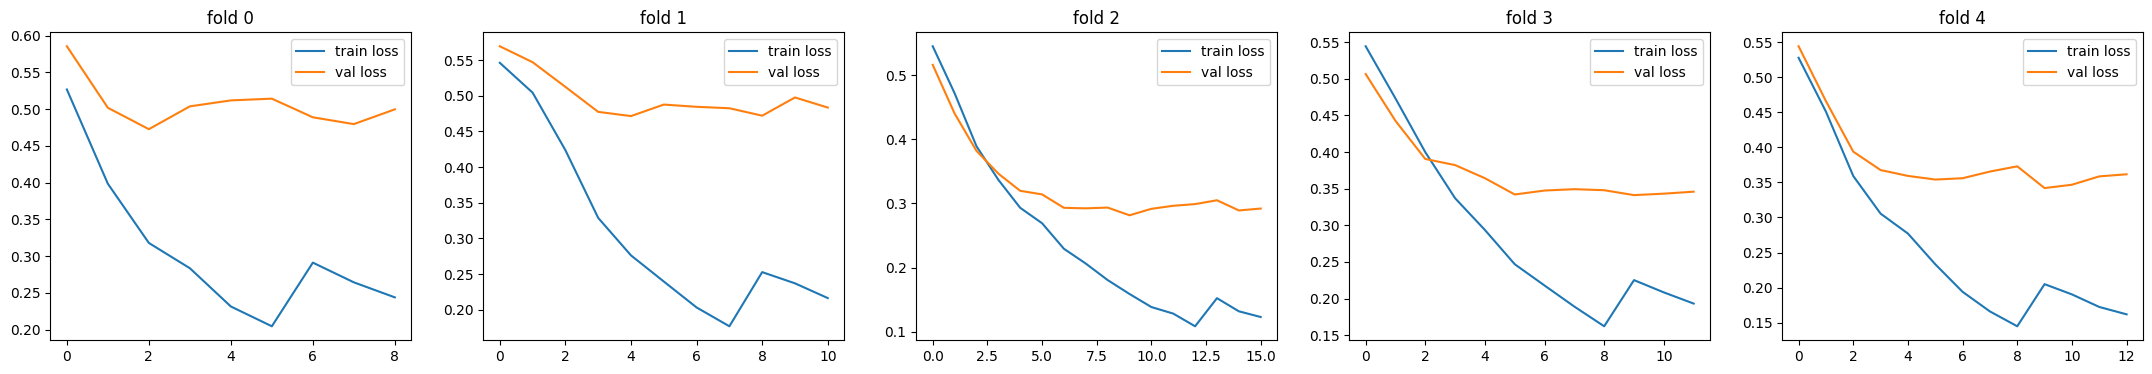

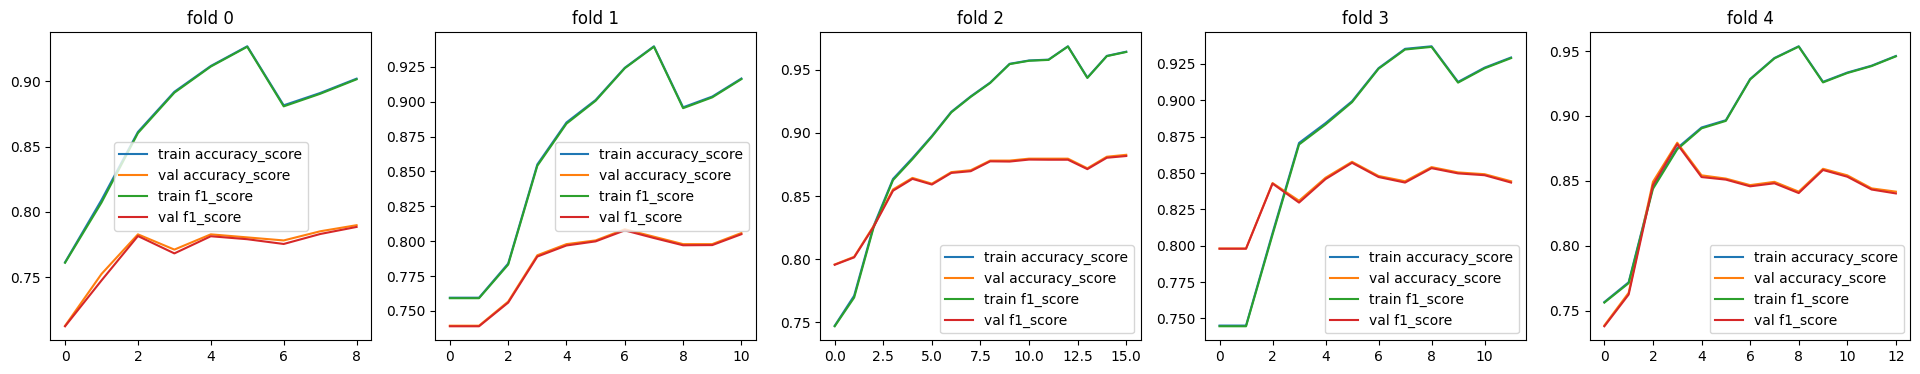

In [25]:
_, axs = plt.subplots(ncols = len(roberta_models), figsize=(27, 4)) 
for fold, train_data in enumerate(roberta_models):
    temp_list = [t["loss"] for t in train_data["data"]["train"]]
    train_metric = []
    for l in temp_list:
        train_metric += l
    temp_list = [t["loss"] for t in train_data["data"]["val"]]
    val_metric = []
    for l in temp_list:
        val_metric += l
    x = [i for i in range(len(val_metric))]
    axs[fold].plot(x, train_metric, label="train loss")
    axs[fold].plot(x, val_metric, label="val loss")
    axs[fold].set_title(f"fold {fold}")
    axs[fold].legend()
print("Roberta models:")
plt.show()
_, axs = plt.subplots(ncols = len(roberta_models), figsize=(24, 4)) 
for fold, train_data in enumerate(roberta_models):
    for metric in ["accuracy_score", "f1_score"]:
        temp_list = [t[metric] for t in train_data["data"]["train"]]
        train_metric = []
        for l in temp_list:
            train_metric += l
        temp_list = [t[metric] for t in train_data["data"]["val"]]
        val_metric = []
        for l in temp_list:
            val_metric += l
        x = [i for i in range(len(val_metric))]
        axs[fold].plot(x, train_metric, label=f"train {metric}")
        axs[fold].plot(x, val_metric, label=f"val {metric}")
        axs[fold].set_title(f"fold {fold}")
        axs[fold].legend()
plt.show()

# 6.1 test

In [26]:
def test_61(model, dataset, device):
    def to(data, device):
        if isinstance(data, torch.Tensor):
            return data.to(device)
        if isinstance(data, dict):
            return {k: to(v, device) for k, v in data.items()}
    model = model.to(device)
    model.eval()
    predictions, true_labels, errors, error_types, wrong_examples = [], [], [], [], []
    batch_size = dataset.batch_size
    for idx, (inputs, labels) in enumerate(dataset):
        inputs = to(inputs, device)
        with torch.no_grad():
                outputs = model(inputs)
        preds = outputs.argmax(dim=-1).cpu().tolist()
        labels = labels.argmax(dim=-1).tolist()
        for i in range(len(preds)):
            if preds[i] != labels[i]:
                errors.append((idx * batch_size) + i) 
                if labels[i] == 0:
                     error_types.append('FN') #label 0 means that original tensor is [1,0], so both sentences are in the same argument
                else:
                     error_types.append('FP')
                wrong_examples.append((inputs['input_ids'][i].tolist()))
        predictions += preds
        true_labels += labels
        del inputs 
        del outputs
    return (predictions, true_labels), errors, error_types, wrong_examples

In [33]:
(predictions, true_labels), new_e, error_types, wrong_examples = \
    test_61(best_model_legal_bert, get_acr_dataloader(test_cases, AutoTokenizer.from_pretrained(LEGAL_BERT), batch_size=8, verbose=False), device)
predictions = [1-i for i in predictions]
true_labels = [1-i for i in true_labels]
print('f1 score:', f1_score(predictions, true_labels))
print('accuracy score:', accuracy_score(predictions, true_labels))
print('precision score:', precision_score(predictions, true_labels))
print('recall score:', recall_score(predictions, true_labels))

f1 score: 0.6459330143540669
accuracy score: 0.7170172084130019
precision score: 0.6398104265402843
recall score: 0.6521739130434783


In [34]:
print('predicted positives:',predictions.count(1),'     predicted negatives:', predictions.count(0))
print('positive labels:',true_labels.count(1), '     negative labels:', true_labels.count(0))
print('false positives:', error_types.count('FP'), '     false negatives:', error_types.count('FN'), '     total errors:', len(error_types))
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")
for i in range(len(wrong_examples)):
    print('wrong classification number', i + 1,':')
    print(tokenizer.decode(wrong_examples[i]))
    print('Type of error:', error_types[i])
    print()
    print()

predicted positives: 414      predicted negatives: 632
positive labels: 422      negative labels: 624
false positives: 144      false negatives: 152      total errors: 296
wrong classification number 1 :
[CLS] the commission, taking into account the applicant's position in these proceedings and the impact of their outcome on her own financial situation, [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

In [35]:
(predictions, true_labels), new_e, error_types, wrong_examples = \
    test_61(best_model_roberta, get_acr_dataloader(test_cases, AutoTokenizer.from_pretrained(ROBERTA), batch_size=8, verbose=False), device)
predictions = [1-i for i in predictions]
true_labels = [1-i for i in true_labels]
print('f1 score:', f1_score(predictions, true_labels))
print('accuracy score:', accuracy_score(predictions, true_labels))
print('precision score:', precision_score(predictions, true_labels))
print('recall score:', recall_score(predictions, true_labels))

f1 score: 0.5442708333333334
accuracy score: 0.6653919694072657
precision score: 0.495260663507109
recall score: 0.6040462427745664


In [36]:
#print('predicted positives:',predictions.count(0),'     predicted negatives:', predictions.count(1)) These works WITHOUT doing 1-i
#print('positive labels:',true_labels.count(0), '     negative labels:', true_labels.count(1))

print('predicted positives:',predictions.count(1),'     predicted negatives:', predictions.count(0))
print('positive labels:',true_labels.count(1), '     negative labels:', true_labels.count(0))
print('false positives:', error_types.count('FP'), '     false negatives:', error_types.count('FN'), '     total errors:', len(error_types))
tokenizer = AutoTokenizer.from_pretrained(ROBERTA)
for i in range(len(wrong_examples)):
    print('wrong classification number', i + 1,':')
    print(tokenizer.decode(wrong_examples[i]))
    print('Type of error:', error_types[i])
    print()
    print()


predicted positives: 346      predicted negatives: 700
positive labels: 422      negative labels: 624
false positives: 137      false negatives: 213      total errors: 350
wrong classification number 1 :
<s>According to Article 26 (Art. 26), the "Commission may only deal
with the matter after all domestic remedies have been exhausted,
according to the generally recognised rules of international law".
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

In [66]:
maj = [1 for i in range(len(true_labels))]
print('f1 score:', f1_score(maj, true_labels))
print('accuracy score:', accuracy_score(maj, true_labels))
print('precision score:', precision_score(maj, true_labels))
print('recall score:', recall_score(maj, true_labels))

f1 score: 0.7473053892215569
accuracy score: 0.5965583173996176
precision score: 1.0
recall score: 0.5965583173996176


# 6.2: Legal bert m1

In [29]:
def test_62(model, dataset, device):
    def to(data, device):
        if isinstance(data, torch.Tensor):
            return data.to(device)
        if isinstance(data, dict):
            return {k: to(v, device) for k, v in data.items()}
    model = model.to(device)
    model.eval()
    predictions, true_labels, errors, error_types, wrong_examples = [], [], [], [], []
    batch_size = dataset.batch_size
    for idx, (inputs, labels) in enumerate(dataset):
        inputs = to(inputs, device)
        with torch.no_grad():
                outputs = model(inputs)
        preds = outputs.argmax(dim=-1).cpu().tolist()
        labels = labels.argmax(dim=-1).tolist()
        for i in range(len(preds)):
            if preds[i] != labels[i]:
                errors.append((idx * batch_size) + i) 
                if labels[i] == 0:
                     error_types.append('FP')
                else:
                     error_types.append('FN')
                wrong_examples.append((inputs['e1']['input_ids'][i].tolist(),inputs['e2']['input_ids'][i].tolist()))
        predictions += preds
        true_labels += labels
        del inputs 
        del outputs
    return (predictions, true_labels), errors, error_types, wrong_examples

In [47]:
model = Model1(2, LEGAL_BERT).to(device)
model.load_state_dict(torch.load(f"weights/6.2/best_model_legal_bert_m1_fold_{2}")) #fold 2 is best for legal bert m1

<All keys matched successfully>

In [48]:
(predictions, true_labels), new_e, error_types, wrong_examples = test_62(model, ARM_test_dataloader, device)
#predictions = [1-i for i in predictions]
#true_labels = [1-i for i in true_labels]
print('f1 score:', f1_score(true_labels, predictions))
print('accuracy score:', accuracy_score(true_labels,predictions))
print('recall score:', recall_score(true_labels, predictions))
print('precision score:', precision_score(true_labels, predictions))

f1 score: 0.5649504015115729
accuracy score: 0.6230045026606631
recall score: 0.5609756097560976
precision score: 0.5689819219790676


In [50]:
maj = [0 for i in range(len(predictions))] #majority classifier:
print('f1 score:', f1_score(true_labels, maj))
print('accuracy score:', accuracy_score(true_labels, maj))
print('recall score:', recall_score(true_labels, maj))
print('precision score:', precision_score(true_labels, maj))

f1 score: 0.6075805072670276
accuracy score: 0.43634875153499797
recall score: 1.0
precision score: 0.43634875153499797


In [51]:
print('predicted positives:',predictions.count(1),'     predicted negatives:', predictions.count(0)) 
print('positive labels:',true_labels.count(1), '     negative labels:', true_labels.count(0))
print('false positives:', error_types.count('FP'), '     false negatives:', error_types.count('FN'), '     total errors:', len(error_types))
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")
for i in range(len(wrong_examples)):
    print('wrong classification number', i + 1,':')
    print(tokenizer.decode(wrong_examples[i][0]))
    print(tokenizer.decode(wrong_examples[i][1]))
    print('Type of error:', error_types[i])
    print()
    print()


predicted positives: 1051      predicted negatives: 1392
positive labels: 1066      negative labels: 1377
false positives: 453      false negatives: 468      total errors: 921
wrong classification number 1 :
[CLS] the commission, taking into account the applicant's position in these proceedings and the impact of their outcome on her own financial situation, [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

### Legal bert m2

In [74]:
model = Model2(2, LEGAL_BERT).to(device)
model.load_state_dict(torch.load(f"weights/6.2/best_model_legal_bert_m2_fold_{1}")) #fold 1 is the best (validation set) fold for bert m2

<All keys matched successfully>

In [75]:
(predictions, true_labels), new_e, error_types, wrong_examples = test_62(model, ARM_test_dataloader, device) # Funzione da rinominare, un'altra nel training ha lo stesso nome
print('f1 score:', f1_score(true_labels, predictions))
print('accuracy score:', accuracy_score(true_labels, predictions))
print('recall score:', recall_score(true_labels, predictions))
print('precision score:', precision_score(true_labels, predictions))

f1 score: 0.5095264017419705
accuracy score: 0.6311911584117887
recall score: 0.43902439024390244
precision score: 0.6070038910505836
2443 2443


In [76]:
print('predicted positives:',predictions.count(1),'     predicted negatives:', predictions.count(0)) #conto prima positivi, poi negativi
print('positive labels:',true_labels.count(1), '     negative labels:', true_labels.count(0))
print('false positives:', error_types.count('FP'), '     false negatives:', error_types.count('FN'), '     total errors:', len(error_types))
print()
print()
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")
for i in range(len(wrong_examples)):
    print('wrong classification number', i + 1,':')
    print(tokenizer.decode(wrong_examples[i][0]))
    print(tokenizer.decode(wrong_examples[i][1]))
    print('Type of error:', error_types[i])
    print()
    print()

predicted positives: 771      predicted negatives: 1672
positive labels: 1066      negative labels: 1377
false positives: 303      false negatives: 598      total errors: 901


wrong classification number 1 :
[CLS] the commission, taking into account the applicant's position in these proceedings and the impact of their outcome on her own financial situation, [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

Note: in both cases the false negative rate is much greater than the false positive rate. ---> maybe this is due to the fact that recognizing positive might be difficult when very different premises support the same conclusion

### Roberta m1

!!! IMPORTANTE: rerunna la def di ARM dataloader col tokenizer giusto (qui sotto) 

In [30]:
tokenizer = RobertaTokenizer.from_pretrained("FacebookAI/roberta-base")

In [31]:
model = Model1(2, ROBERTA).to(device)
model.load_state_dict(torch.load(f"weights/6.2/best_model_roberta_m1_fold_{2}")) #fold 2 is the best (validation set) fold for roberta m1

<All keys matched successfully>

In [33]:
(predictions, true_labels), new_e, error_types, wrong_examples = test_62(model, get_arm_dataloader(test_cases, tokenizer, batch_size=8), device)
print('f1 score:', f1_score(true_labels, predictions))
print('accuracy score:', accuracy_score(true_labels, predictions))
print(len(predictions), len(true_labels))


f1 score: 0.6098334655035685
accuracy score: 0.5972165370446173
2443 2443


In [34]:
print('predicted positives:',predictions.count(1),'     predicted negatives:', predictions.count(0)) #conto prima positivi, poi negativi
print('positive labels:',true_labels.count(1), '     negative labels:', true_labels.count(0))
print('false positives:', error_types.count('FP'), '     false negatives:', error_types.count('FN'), '     total errors:', len(error_types))
print()
print()

for i in range(len(wrong_examples)):
    print('wrong classification number', i + 1,':')
    print(tokenizer.decode(wrong_examples[i][0]))
    print(tokenizer.decode(wrong_examples[i][1]))
    print('Type of error:', error_types[i])
    print()
    print()

predicted positives: 1456      predicted negatives: 987
positive labels: 1066      negative labels: 1377
false positives: 687      false negatives: 297      total errors: 984


wrong classification number 1 :
<s> The
Commission, taking into account the applicant's position in these
proceedings and the impact of their outcome on her own financial
situation,</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
<s>finds that the applicant is entitled to complain about the
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

In questo caso false positive e negati rates sono simili

### Roberta m2

In [35]:
model = Model2(2, ROBERTA).to(device)
model.load_state_dict(torch.load(f"weights/6.2/best_model_roberta_m2_fold_{2}")) #fold 2 is the best (validation set) fold for roberta m1

<All keys matched successfully>

In [48]:
(predictions, true_labels), new_e, error_types, wrong_examples = test_62(model, ARM_test_dataloader, device)
print('f1 score:', f1_score(true_labels, predictions))
print('accuracy score:', accuracy_score(true_labels, predictions))
print(len(predictions), len(true_labels))

f1 score: 0.7209424083769633
accuracy score: 0.563651248465002
2443 2443


In [49]:
print('predicted positives:',predictions.count(0),'     predicted negatives:', predictions.count(1)) #conto prima positivi, poi negativi
print('positive labels:',true_labels.count(0), '     negative labels:', true_labels.count(1))
print('false positives:', error_types.count('FP'), '     false negatives:', error_types.count('FN'), '     total errors:', len(error_types))
print()
print()

for i in range(len(wrong_examples)):
    print('wrong classification number', i + 1,':')
    print(tokenizer.decode(wrong_examples[i][0]))
    print(tokenizer.decode(wrong_examples[i][1]))
    print('Type of error:', error_types[i])
    print()
    print()

predicted positives: 0      predicted negatives: 2443
positive labels: 1066      negative labels: 1377
false positives: 0      false negatives: 1066      total errors: 1066


wrong classification number 1 :
 like%A couldem0os% G your Bian go Maydth% hearing market President sister did June behind 11 Now coulda<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
 likeES know% G under care D Mount thought% required market%d noa<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s

# Evaluation of models for task 3:

In [37]:
legal_bert_models = []
for fold in range(5):
    f = open(f"trainings/6.3/legal_bert_fold_{fold}.json")
    data = json.load(f)
    model = ModelPCR(2, LEGAL_BERT)
    model.load_state_dict(torch.load(f"weights/6.3/best_model_legal_bert_fold_{fold}"))
    losses = [train["loss"] for train in data["val"]]
    f1s = [train["f1_score"] for train in data["val"]]
    loss = []
    f1 = []
    for l in losses:
        loss += l
    for f in f1s:
        f1 += f
    min_loss = min(loss)
    f1 = f1[loss.index(min_loss)]
    legal_bert_models.append({"loss": min_loss, "data":data, "model": model, "f1":f1})
    
roberta_models = []
for fold in range(5):
    f = open(f"trainings/6.3/roberta_fold_{fold}.json")
    data = json.load(f)
    model = ModelPCR(2, ROBERTA)
    model.load_state_dict(torch.load(f"weights/6.3/best_model_roberta_fold_{fold}"))
    losses = [train["loss"] for train in data["val"]]
    f1s = [train["f1_score"] for train in data["val"]]
    loss = []
    f1 = []
    for l in losses:
        loss += l
    for f in f1s:
        f1 += f
    min_loss = min(loss)
    f1 = f1[loss.index(min_loss)]
    roberta_models.append({"loss": min_loss, "data":data, "model": model, "f1":f1})
    
best_model_legal_bert = ModelPCR(2, LEGAL_BERT)
best_model_fold_legal_bert = max(legal_bert_models, key= lambda x: x["f1"]) 
best_model_legal_bert.load_state_dict(best_model_fold_legal_bert["model"].state_dict())
best_model_legal_bert = best_model_legal_bert.to(device)
best_model_legal_bert.eval()

best_model_roberta = ModelPCR(2, ROBERTA)
best_model_fold_roberta = max(roberta_models, key= lambda x: x["f1"]) 
best_model_roberta.load_state_dict(best_model_fold_roberta["model"].state_dict())
best_model_roberta = best_model_roberta.to(device)
best_model_roberta.eval();

In [38]:
def test_63(model, dataset, device):
    def to(data, device):
        if isinstance(data, torch.Tensor):
            return data.to(device)
        if isinstance(data, dict):
            return {k: to(v, device) for k, v in data.items()}
    model = model.to(device)
    model.eval()
    predictions, true_labels, errors, error_types, wrong_examples = [], [], [], [], []
    batch_size = dataset.batch_size
    for idx, (inputs, labels) in enumerate(dataset):
        inputs = to(inputs, device)
        with torch.no_grad():
                outputs = model(inputs)
        preds = torch.nn.functional.sigmoid(outputs).round().cpu().tolist()
        labels = torch.nn.functional.sigmoid(labels).round().tolist()
        for i in range(len(preds)):
            for k in [0,1]:
                if preds[i][k] != labels[i][k]:
                    errors.append((idx * batch_size) + i) 
                    if labels[i][k] == 0:
                        error_types.append('FN') #label 0 means that original tensor is [1,0], so both sentences are in the same argument
                    else:
                        error_types.append('FP')
                    wrong_examples.append((inputs['input_ids'][i].tolist(),k))
        predictions += preds
        true_labels += labels
        del inputs 
        del outputs
    return (predictions, true_labels), errors, error_types, wrong_examples

In [39]:
(predictions, true_labels), new_e, error_types, wrong_examples = \
    test_63(best_model_legal_bert, get_pcr_dataloader(test_cases, AutoTokenizer.from_pretrained(LEGAL_BERT), batch_size=8, verbose=False), device)
print('f1 score:', f1_score(predictions, true_labels, average="macro")) #vedere anche per ciascuna label separatamente
print('accuracy score:', accuracy_score(predictions, true_labels))

f1 score: 0.7868852459016393
accuracy score: 0.7914438502673797


In [40]:
print('predicted positives:',predictions.count(0),'     predicted negatives:', predictions.count(1)) #conto prima positivi, poi negativi
print('positive labels:',true_labels.count(0), '     negative labels:', true_labels.count(1))
print('false positives:', error_types.count('FP'), '     false negatives:', error_types.count('FN'), '     total errors:', len(error_types))
print()
print()
tokenizer = AutoTokenizer.from_pretrained(LEGAL_BERT)
for i in range(len(wrong_examples)):
    print('wrong classification number', i + 1,':')
    print(tokenizer.decode(wrong_examples[i][0]))
    print(tokenizer.decode(wrong_examples[i][1]))
    print('Type of error:', error_types[i])
    print()
    print()

predicted positives: 0      predicted negatives: 0
positive labels: 0      negative labels: 0
false positives: 87      false negatives: 92      total errors: 179


wrong classification number 1 :
[CLS] the commission finds that it is thus not faced with the issue of an alleged absence of any reaction of the competent court to a procedural request ( cf. no. 19369 / 92, dec. 8. 1. 93, not published ). [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[unused0]
Type of error: FP


wrong classification number 2 :
[CLS] i

In [41]:
(predictions, true_labels), new_e, error_types, wrong_examples = \
    test_63(best_model_roberta, get_pcr_dataloader(test_cases, AutoTokenizer.from_pretrained(ROBERTA), batch_size=8, verbose=False), device)
print('f1 score:', f1_score(predictions, true_labels, average="macro")) #vedere anche per ciascuna label separatamente
print('accuracy score:', accuracy_score(predictions, true_labels))

f1 score: 0.7721390471572311
accuracy score: 0.768270944741533


In [42]:
print('predicted positives:',predictions.count(0),'     predicted negatives:', predictions.count(1)) #conto prima positivi, poi negativi
print('positive labels:',true_labels.count(0), '     negative labels:', true_labels.count(1))
print('false positives:', error_types.count('FP'), '     false negatives:', error_types.count('FN'), '     total errors:', len(error_types))
print()
print()
tokenizer = AutoTokenizer.from_pretrained(ROBERTA)
for i in range(len(wrong_examples)):
    print('wrong classification number', i + 1,':')
    print(tokenizer.decode(wrong_examples[i][0]))
    print(tokenizer.decode(wrong_examples[i][1]))
    print('Type of error:', error_types[i])
    print()
    print()

predicted positives: 0      predicted negatives: 0
positive labels: 0      negative labels: 0
false positives: 95      false negatives: 99      total errors: 194


wrong classification number 1 :
<s>The Commission finds that it is thus not faced with the issue of
an alleged absence of any reaction of the competent court to a
procedural request (cf. No. 19369/92, Dec. 8.1.93, not published).</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
<pad>
Type of error: FP


wrong classification number 2 :
<s>In
the circumstances of the present case, a request under S. 91 of the
Court Organisation Act cannot be considered as an effective remedy to
ensure, regardi